In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mini-sparkify/mini_sparkify_event_data.json


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285413 sha256=7441c8b71e4a5346c3acbf11712942449eba7cd46129fa03aa5576b9da16f80f
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [3]:
!pip install httpagentparser

  Preparing metadata (setup.py) ... done
  Created wheel for httpagentparser: filename=httpagentparser-1.9.5-py3-none-any.whl size=7560 sha256=cf6b6121d863161038de8509ee0fdf4f44c8907af3c6c5019d2613734bbff5c3
  Stored in directory: /root/.cache/pip/wheels/5f/26/99/025f2881066a9c7a12edf5792cdaad9f6061c517c9e4c9875a
Successfully built httpagentparser


In [4]:
!pip install awscli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 46.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 66.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 29.6 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.20.1
    Uninstalling docutils-0.20.1:
      Successfully uninstalled docutils-0.20.1
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.6
    Uninstalling colorama-0.4.6:
      Successfully uninstalled colorama-0.4.6
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.76
    Uninstalling botocore-1.29.76:
      Successfully uninstalled botocore-1.29.76
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [5]:
# !aws s3 cp s3://udacity-dsnd/sparkify/sparkify_event_data.json /kaggle/working/ --no-sign-request

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [6]:
# import libraries
from pyspark.sql import SparkSession

# create a Spark session
spark = SparkSession.builder.master("local[*]").appName("Sparkify").getOrCreate()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/28 13:20:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
# mini sparkify file path
mini_data_path = '/kaggle/input/mini-sparkify/mini_sparkify_event_data.json'

# large sparkify file path (12 Gb)
large_data_path = '/kaggle/working/sparkify_event_data.json'

# load sparkify data
df = spark.read.json(mini_data_path)
df.printSchema()
df.show(5)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|     

In [8]:
from pyspark.sql.functions import col, when, count, isnan

# get the missing values for each column in the DataFrame
missing_values = df.select([count(when(isnan(c) | col(c).isNull() | (col(c)=='') , c)).alias(c) for c in df.columns])
missing_values.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
from functools import reduce
# get all the df rows with missing values
rows_with_missing_values = df.filter(reduce(lambda a, b: a |b, [(col(x).isNull() | col(x).isin('') | isnan(col(x))) for x in df.columns]))
rows_with_missing_values.show(5)
number_of_rows_original = df.count()
print("Total number of rows: ", number_of_rows_original)
print("Number of rows with missing values: ", rows_with_missing_values.count())

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

Total number of rows:  286500


Number of rows with missing values:  58392


**User information cleaning:**

Since our objective is to predict user churn then user information is crucial. Therefore, we need to drop the rows presenting missing values in either of the following columns: `userId`, `userAgent`, `registration`, `location`, `firstName`, `lastName`, `gender`.

In [10]:
# drop rows with missing values
df = df.dropna(subset=['userId', 'firstName', 'lastName', 'location', 'userAgent', 'registration', 'gender'], how='any')
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [11]:
# get all the df rows with missing values
df.agg(*[((count('*') - count(c) )).alias(c + '_null_number') for c in df.columns]).show()

+------------------+----------------+---------------------+------------------+-------------------------+--------------------+------------------+-----------------+--------------------+------------------+----------------+------------------------+---------------------+----------------+------------------+--------------+---------------------+------------------+
|artist_null_number|auth_null_number|firstName_null_number|gender_null_number|itemInSession_null_number|lastName_null_number|length_null_number|level_null_number|location_null_number|method_null_number|page_null_number|registration_null_number|sessionId_null_number|song_null_number|status_null_number|ts_null_number|userAgent_null_number|userId_null_number|
+------------------+----------------+---------------------+------------------+-------------------------+--------------------+------------------+-----------------+--------------------+------------------+----------------+------------------------+---------------------+----------------

In [12]:
# get all the df rows with missing values in percentage
df.agg(*[((1 - (count(c) / count('*')))).alias(c + '_null_percent') for c in df.columns]).show()

+-------------------+-----------------+----------------------+-------------------+--------------------------+---------------------+-------------------+------------------+---------------------+-------------------+-----------------+-------------------------+----------------------+-------------------+-------------------+---------------+----------------------+-------------------+
|artist_null_percent|auth_null_percent|firstName_null_percent|gender_null_percent|itemInSession_null_percent|lastName_null_percent|length_null_percent|level_null_percent|location_null_percent|method_null_percent|page_null_percent|registration_null_percent|sessionId_null_percent|  song_null_percent|status_null_percent|ts_null_percent|userAgent_null_percent|userId_null_percent|
+-------------------+-----------------+----------------------+-------------------+--------------------------+---------------------+-------------------+------------------+---------------------+-------------------+-----------------+------------

In [13]:
print("Total number of rows after dropping rows with missing values in userId:", df.count())
rows_with_missing_values_user_info = df.filter(reduce(lambda a, b: a |b, [(col(x).isNull() | col(x).isin('') | isnan(col(x))) for x in ['userId']]))
print("Number of rows with missing values for user info after dropping rows with missing values in userId: ", rows_with_missing_values_user_info.count())
print("Difference in number of rows: ", number_of_rows_original - df.count())

Total number of rows after dropping rows with missing values in userId: 278154


Number of rows with missing values for user info after dropping rows with missing values in userId:  0


Difference in number of rows:  8346


**Content information cleaning:**


Since we are looking for behavioral pattern in user activity, we cannot simply drop the rows with missing values in `artist` or `song` columns. In fact, a user could be interacting with the platform regardless if he/she was listening to a song or not. So, we can create a new column called `Listening` that will be equal to 1 if the user was listening to a song and 0 otherwise. This would allow us to retain almost 18% of the user data.

In [14]:
# get all the df rows with missing values
rows_with_missing_values_content = df.filter(reduce(lambda a, b: a |b, [(col(x).isNull() | col(x).isin('') | isnan(col(x))) for x in ['artist', 'song']]))
rows_with_missing_values_content.show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [15]:
# create a new column to indicate whether the user is listening to music
df = df.withColumn('Listening', when(col('song').isNotNull(), 1).otherwise(0))
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Listening|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|        1|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambr

In [16]:
df.filter(col('Listening')==0).show(5)
print("Number of status not Listening: ", df.filter(col('Listening')==0).count())
print("Correponds to the number of missing values due to content: ", rows_with_missing_values_content.count())

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+---------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|Listening|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+---------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|        0|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win..

Number of status not Listening:  50046


Correponds to the number of missing values due to content:  50046


The fact that the number of rows where a user is not listening to music is almost the same as the number of missing values (3 instances with issues), shows that we have avoided dropping rows with missing values in `artist` or `song` columns.

In [17]:
# Filter out rows where 'Listening' is 1 but there are missing values in 'artist' or 'song'
df = df.filter(~((col('Listening') == 1) & (col('artist').isNull() | col('song').isNull())))

# Check the count again
print("Number of status not Listening: ", df.filter(col('Listening')==0).count())


Number of status not Listening:  50046


In [18]:
print("The pages visited by users who are listening to music: ") 
df.filter(col('Listening')==1).select('page').distinct().show()
print("The pages visited by users who are not listening to music: ") 
df.filter(col('Listening')==0).select('page').distinct().show()

The pages visited by users who are listening to music: 


+--------+
|    page|
+--------+
|NextSong|
+--------+

The pages visited by users who are not listening to music: 


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [19]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [20]:
from pyspark.sql.functions import when, max, col
from pyspark.sql import Window

# Create a new column "churn" based on the value of the page column
df = df.withColumn("churn", when(col("page") == "Cancellation Confirmation", 1).otherwise(0))

# Define window to group by 'userId'
window_churn = Window.partitionBy('userId')

# Update churn column with the max value of the churn for each user
df = df.withColumn("churn", max("churn").over(window_churn))

# Show the result 
df.filter(col("churn") == 1).show(5)


+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Listening|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+-----+
|            Gorillaz|Logged In|  Rodrigo|     M|            0|   Carey|215.19628| paid|New York-Newark-J...|   PUT|NextSong|1535389443000|       37|Welcome To The Wo...|   200|1539177136000|"Mozilla/5.0 (Win...|100014|        1|    1|
|The Cinematic Orc...|Logged In|  Rodrigo|     M|       


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### User Churn Distribution

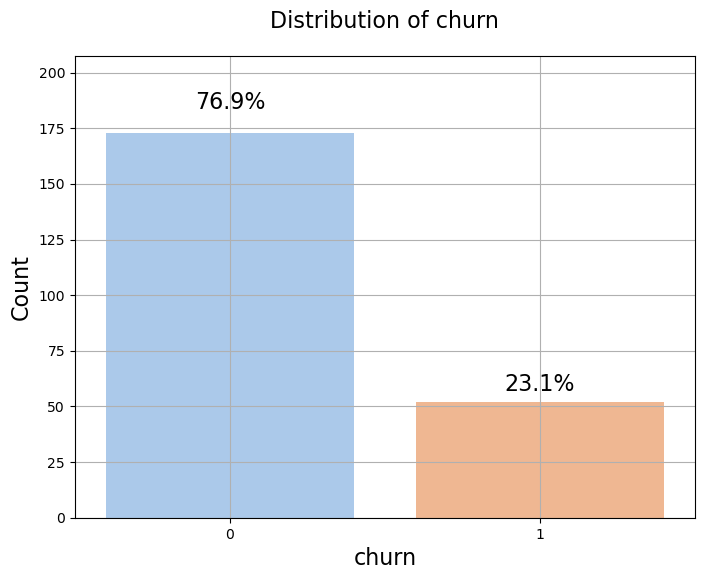

In [21]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

def annotate_and_format(ax, df, title, xlabel, ylabel, annotation_rotation):
    """
    Annotate percentages and set the title, xlabel, and ylabel for a seaborn countplot.

    Args:
        ax: The axis object
        df: Dataframe
        title: Title of the plot
        xlabel: Label for x-axis
        ylabel: Label for y-axis

    Returns:
        None
    """
    # Annotate percentages
    for patch in ax.patches:
        x, y, width, height = patch.get_bbox().bounds
        percentage = f'{((height / len(df)) * 100).round(1)}%'
        x += width/2
        y += height + 0.05*height
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=16, rotation=annotation_rotation)

    # Format title and labels
    ax.set_title(title, pad=20, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid(True)

def plot_bar(df, column_to_check, fig_tuple=(8,6), rotation=90, annotation_rotation=90):
    plt.figure(figsize=fig_tuple)
    sns.set_palette("pastel")
    df = df.toPandas()
    ax = sns.countplot(x = column_to_check, data=df, order= df[column_to_check].value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
    ax.set_ylim(0, 1.2*df[column_to_check].value_counts().max())
    annotate_and_format(ax, df, f'Distribution of {column_to_check}', column_to_check, 'Count', annotation_rotation)

    
def aggregate_col(df, column_to_check, func):
    """
    Aggregate a column of a spark dataframe
    
    Args:
        df: spark dataframe
        column_to_check: column to aggregate
        func: aggregation function to apply to the column (e.g. count, avg, sum, etc.)
        
    Returns:
        df: pandas dataframe with the aggregated column
    """
    exp = df.select(['userId', column_to_check])\
        .groupBy('userId')\
        .agg({f'{column_to_check}':f'{func}'})
    exp = exp.withColumnRenamed(f"{func}({column_to_check})", f"{column_to_check}")
        
    return exp


def visualize_col(df, column_to_check, func, fig_tuple=(8,6), rotation=0, annotation_rotation=0):
    """
    Create a Barplot to vizualize categorical columns
    
    Args:
        df: spark dataframe
        column_to_check: categorical column to plot
        func: aggregation function to apply to the column (e.g. count, avg, sum, etc.)
        fig_tuple: tuple of integers to set the figure size
        
    Returns:
        None
    """
    # aggregate column
    exp_pd = aggregate_col(df, column_to_check, func)
    
    # Plot a barplot using seaborn 
    plot_bar(exp_pd, column_to_check, fig_tuple, rotation, annotation_rotation)


visualize_col(df, 'churn', 'max')

#### User Gender Distribution

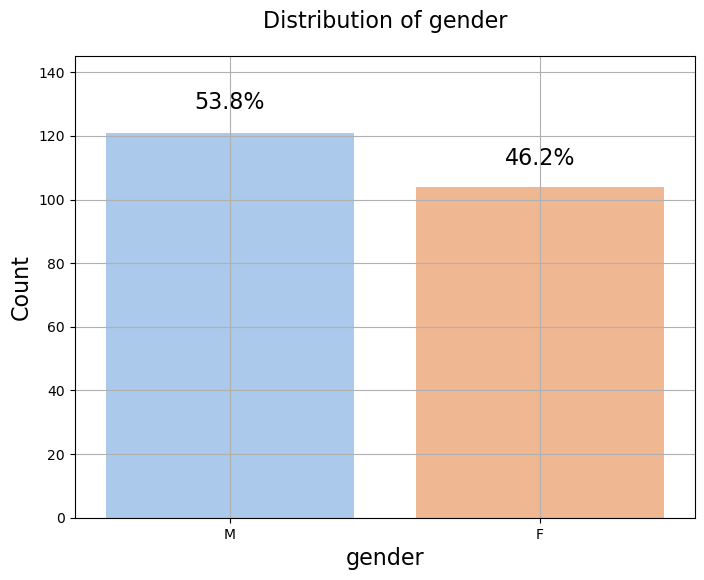

In [22]:
visualize_col(df, 'gender', 'last')

#### User Subscription level Distribution

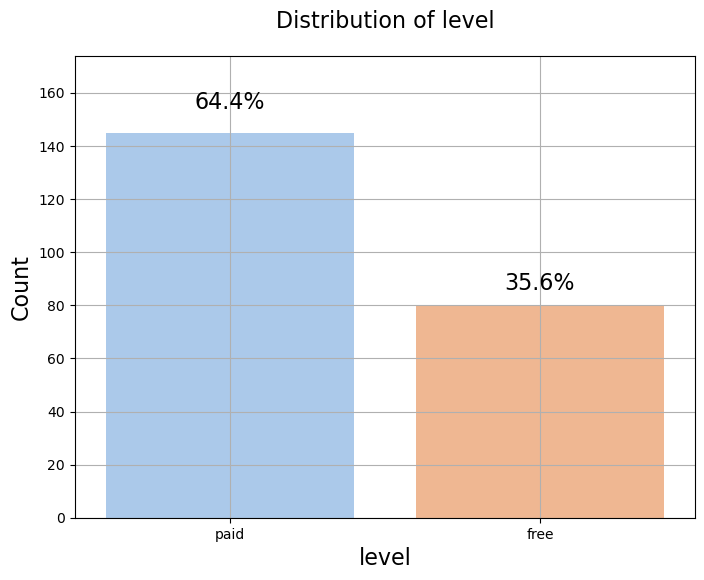

In [23]:
visualize_col(df, 'level', 'last')

#### UserAgent Distribution

In [24]:
import httpagentparser
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField

# define function to parse the browser and the platfrom 
def parse_agent(userAgent):
    """
    Get the browser and the platform from the user agent
    
    Args:
        userAgent: user agent string
        
    Returns:
        platform: platform used by the user (e.g. Windows, Mac, etc.)
        browser: browser used by the user (e.g. Chrome, Safari, etc.)
    """
    fields = httpagentparser.detect(userAgent)
    platform = fields['platform']['name']
    browser = fields['browser']['name']
    return platform, browser


# define schema for the udf function 
schema = StructType([
    StructField('platform', StringType()),
    StructField('browser', StringType()),
])

# create a udf to make it work with pyspark  
parse_agent_udf = udf(parse_agent, schema)

# apply the udf to df to create a new column with the platform and the browser
df = df.withColumn('Agent_extract', parse_agent_udf('userAgent'))

# Seperate the platform and the browser in two different columns
df = df.withColumn('platform', df['Agent_extract']['platform'])\
    .withColumn('browser', df['Agent_extract']['browser'])

df.select(['userId','platform', 'browser']).show()

+------+--------+-------+
|userId|platform|browser|
+------+--------+-------+
|    30| Windows|Firefox|
|     9| Windows| Chrome|
|    30| Windows|Firefox|
|     9| Windows| Chrome|
|    30| Windows|Firefox|
|     9| Windows| Chrome|
|     9| Windows| Chrome|
|    30| Windows|Firefox|
|    30| Windows|Firefox|
|    30| Windows|Firefox|
|     9| Windows| Chrome|
|     9| Windows| Chrome|
|    30| Windows|Firefox|
|     9| Windows| Chrome|
|     9| Windows| Chrome|
|    30| Windows|Firefox|
|     9| Windows| Chrome|
|    74|  Mac OS| Chrome|
|    30| Windows|Firefox|
|     9| Windows| Chrome|
+------+--------+-------+
only showing top 20 rows



In [25]:
v = df.select(['userId', 'Agent_extract']).distinct().groupby(['userId']).count()
v.describe().show()

+-------+------------------+-----+
|summary|            userId|count|
+-------+------------------+-----+
|  count|               225|  225|
|   mean|65391.013333333336|  1.0|
| stddev|105396.47791907164|  0.0|
|    min|                10|    1|
|    max|                99|    1|
+-------+------------------+-----+



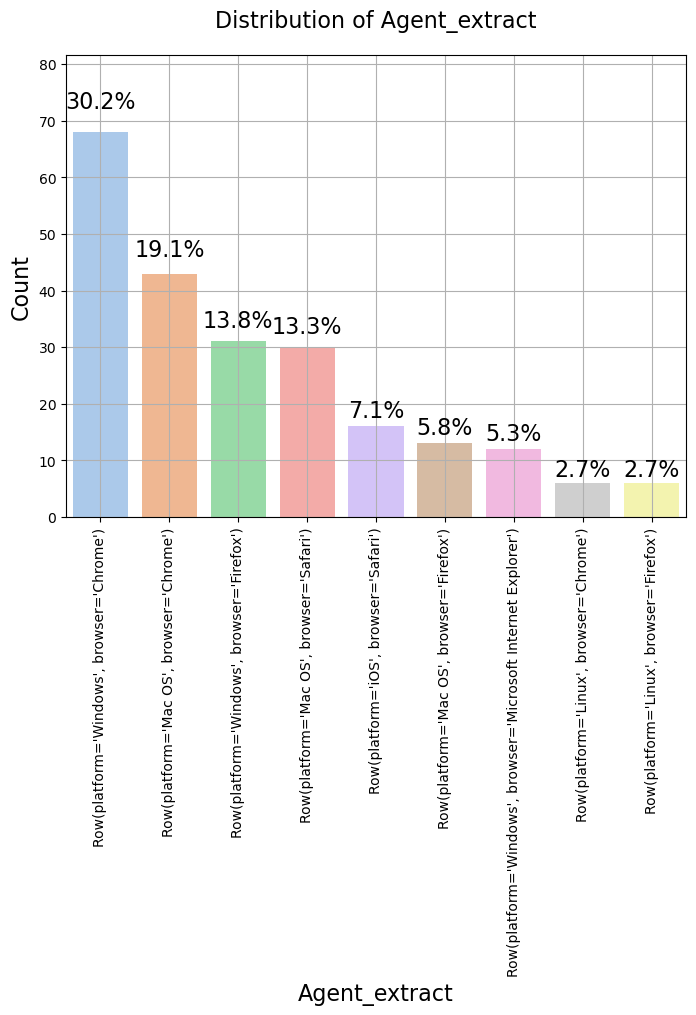

In [26]:
visualize_col(df, 'Agent_extract', 'last', rotation=90)

#### User Platfom Distribution

In [27]:
# Get the type of platform used by the users
df.select(['platform']).distinct().show()

+--------+
|platform|
+--------+
|     iOS|
|  Mac OS|
|   Linux|
| Windows|
+--------+



We make the assumption that the user is only using a single platform to access his account. 

The assumption is partially validated by the data sample we are using, but it doesn't rule out multi-platform usage.

In [28]:
# verify is a user can use multiple platforms
v = df.select(['userId','platform']).distinct().groupby(['userId']).count()
v.describe().show()

+-------+------------------+-----+
|summary|            userId|count|
+-------+------------------+-----+
|  count|               225|  225|
|   mean|65391.013333333336|  1.0|
| stddev|105396.47791907162|  0.0|
|    min|                10|    1|
|    max|                99|    1|
+-------+------------------+-----+



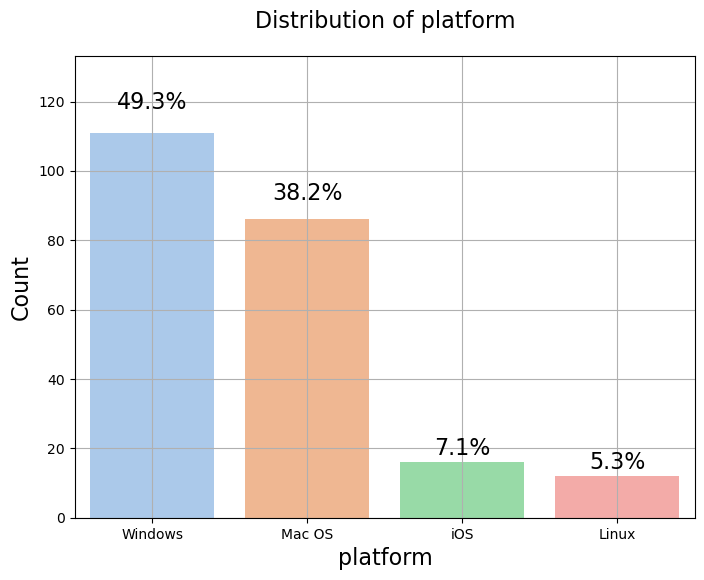

In [29]:
visualize_col(df, 'platform', 'last')

#### User Browser Distribution



In [30]:
# Get the type of browser used by the users
df.select(['browser']).distinct().show()

+--------------------+
|             browser|
+--------------------+
|             Firefox|
|              Safari|
|Microsoft Interne...|
|              Chrome|
+--------------------+



We make the assumption that the user is only using a single browser to access his account. 
The assumption is partially validated by the data.

In [31]:
# Check if a user can use multiple browsers
v = df.select(['userId','browser']).distinct().groupby(['userId']).count()
v.describe().show()

+-------+------------------+-----+
|summary|            userId|count|
+-------+------------------+-----+
|  count|               225|  225|
|   mean|65391.013333333336|  1.0|
| stddev|105396.47791907164|  0.0|
|    min|                10|    1|
|    max|                99|    1|
+-------+------------------+-----+



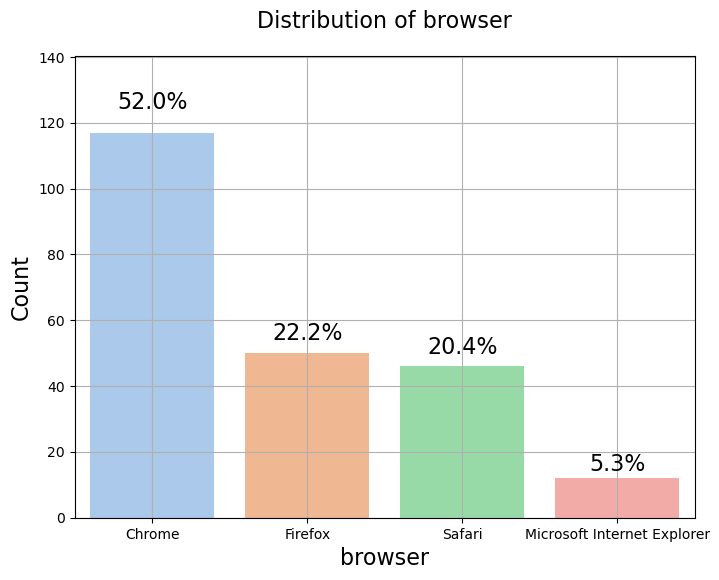

In [32]:
visualize_col(df, 'browser', 'last')

#### User Location

In [33]:
df.select(['location']).distinct().toPandas()

,location
0,"Gainesville, FL"
1,"Atlantic City-Hammonton, NJ"
2,"Deltona-Daytona Beach-Ormond Beach, FL"
3,"San Diego-Carlsbad, CA"
4,"Kingsport-Bristol-Bristol, TN-VA"
...,...
109,"Jacksonville, NC"
110,"Portland-Vancouver-Hillsboro, OR-WA"
111,"Colorado Springs, CO"
112,"Wilson, NC"


In [34]:
from pyspark.sql.functions import split
 
# Add column with City
df = df.withColumn("City", split(df['location'], ',')[0])

# Add column with State
df = df.withColumn("State", split(split(df['location'], ',')[1], '-')[0])

# First, define a dictionary that maps each state to a region
state_to_region = {
    'WA': 'West', 'OR': 'West', 'CA': 'West', 'NV': 'West', 'AZ': 'Southwest',
    'ID': 'West', 'MT': 'West', 'WY': 'West', 'UT': 'West', 'CO': 'West',
    'NM': 'Southwest', 'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest',
    'KS': 'Midwest', 'OK': 'South', 'TX': 'South', 'MN': 'Midwest', 'IA': 'Midwest',
    'MO': 'Midwest', 'AR': 'South', 'LA': 'South', 'WI': 'Midwest', 'IL': 'Midwest',
    'MS': 'South', 'MI': 'Midwest', 'IN': 'Midwest', 'KY': 'South', 'TN': 'South',
    'AL': 'South', 'GA': 'South', 'FL': 'South', 'OH': 'Midwest', 'WV': 'South',
    'PA': 'Northeast', 'VA': 'South', 'NC': 'South', 'SC': 'South', 'NY': 'Northeast',
    'ME': 'Northeast', 'VT': 'Northeast', 'NH': 'Northeast', 'MA': 'Northeast',
    'RI': 'Northeast', 'CT': 'Northeast', 'NJ': 'Northeast', 'DE': 'South',
    'MD': 'South', 'HI': 'West', 'AK': 'West', 'DC': 'South'
}

# define udf function to map state to region
def get_region(state):
    """
    Get the region from the state
    
    Args:
        state: state abbreviation
        
    Returns:
        region: region of the state
    """
    # remove spaces and convert to uppercase
    state = state.strip().upper()
    region = state_to_region[state]
    return region

# define udf function to map state to region
get_region_udf = udf(get_region, StringType())


# Map state to region
df = df.withColumn('Region', get_region_udf(df['State']))

df.show()

23/06/28 13:23:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+-----+-----------------+--------+-------+--------------------+-----+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Listening|churn|    Agent_extract|platform|browser|                City|State|Region|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+-----+-----------------+--------+-------+--------------------+-----+------+
|         OneRepublic|Logged In|  Bryanna|     F|            0|   Stone|224.67873| pa

#### User Distribution by State

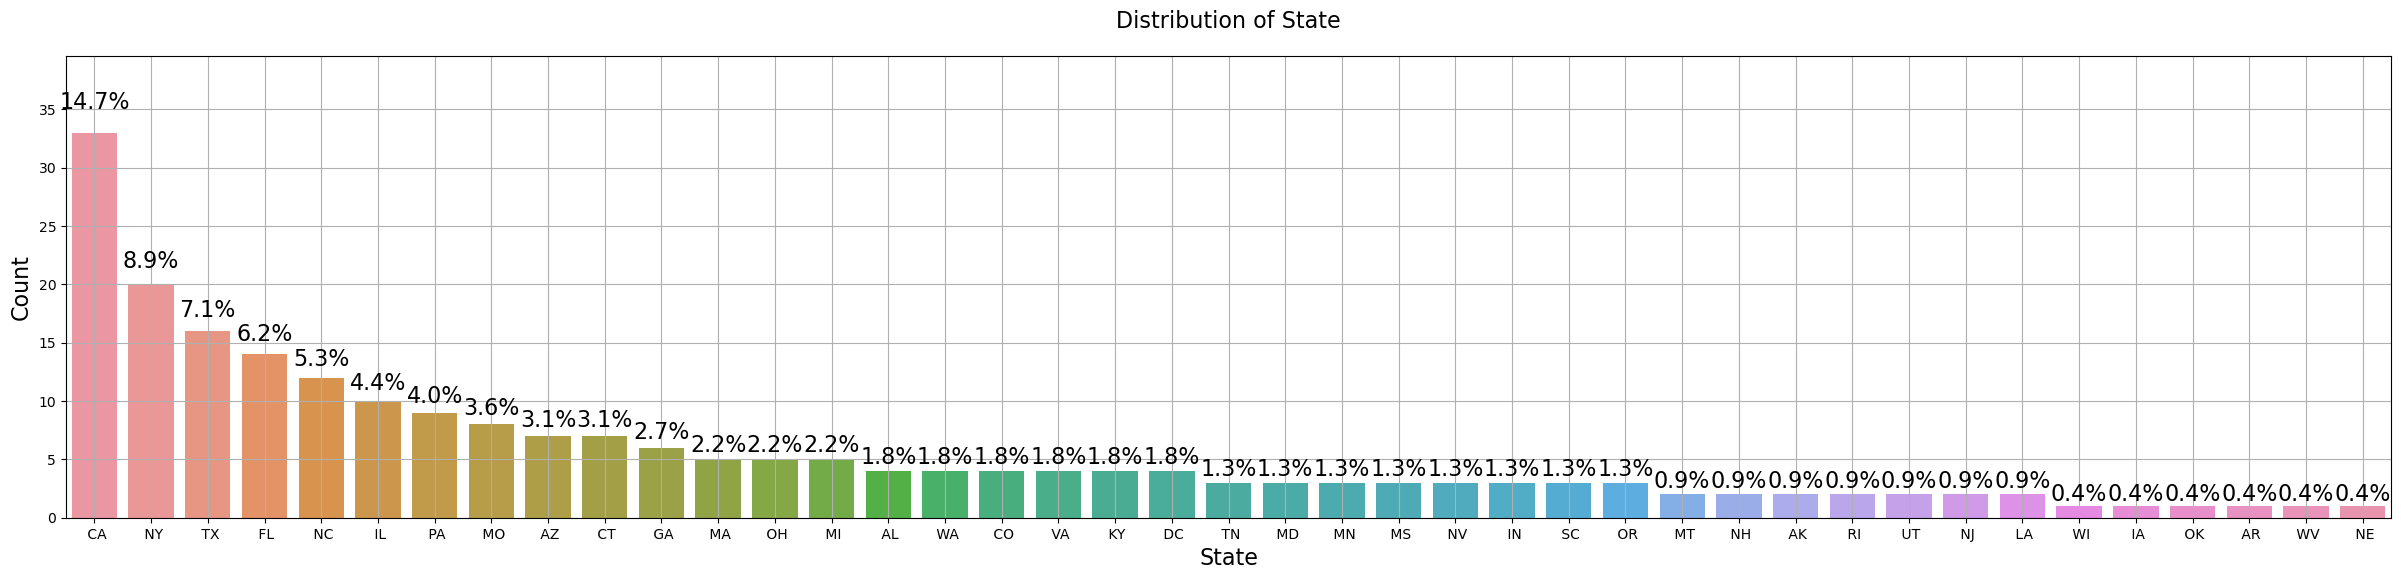

In [35]:
visualize_col(df, 'State', 'last',(30, 6))

#### User Distribution by City

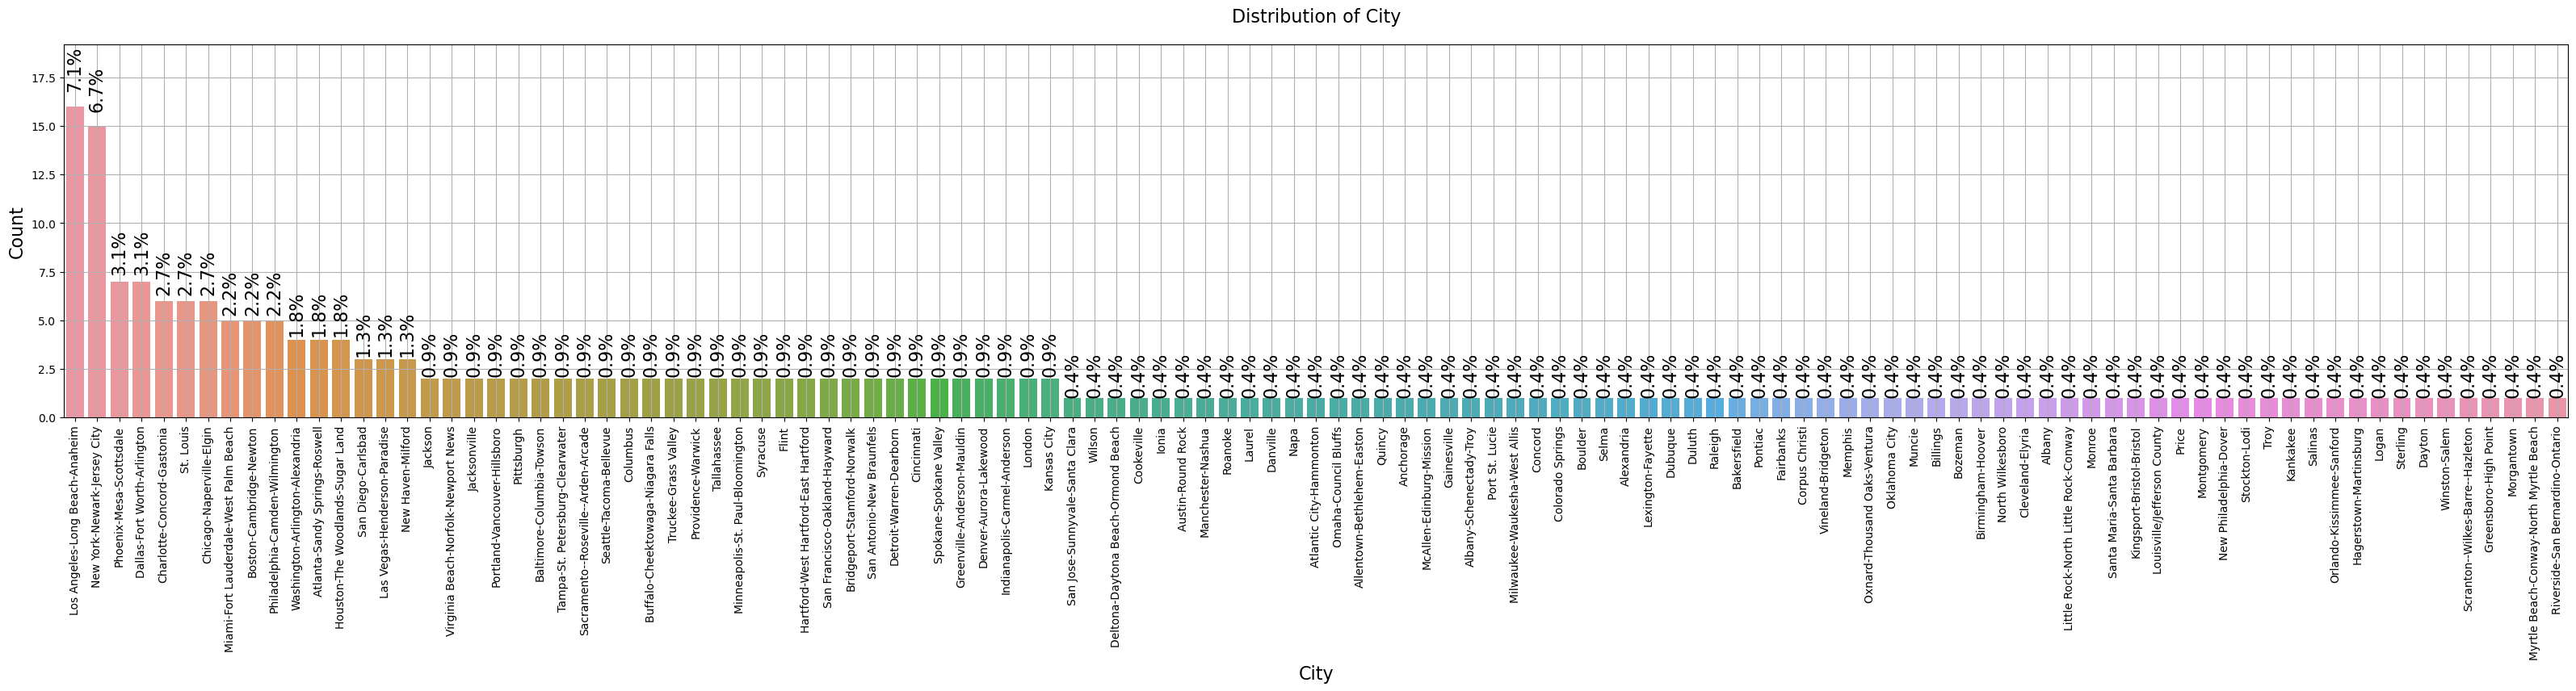

In [36]:
visualize_col(df, 'City', 'last', (40,6), rotation=90, annotation_rotation=90)

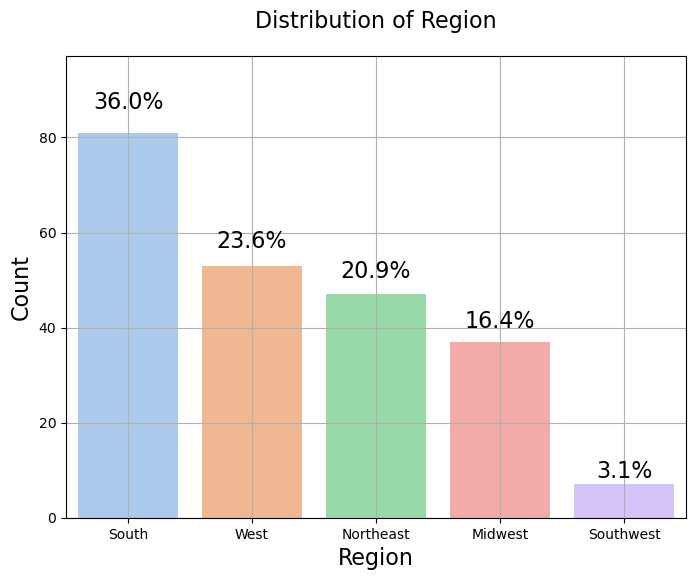

In [37]:
visualize_col(df, 'Region', 'last')

#### Page distribution (overall)

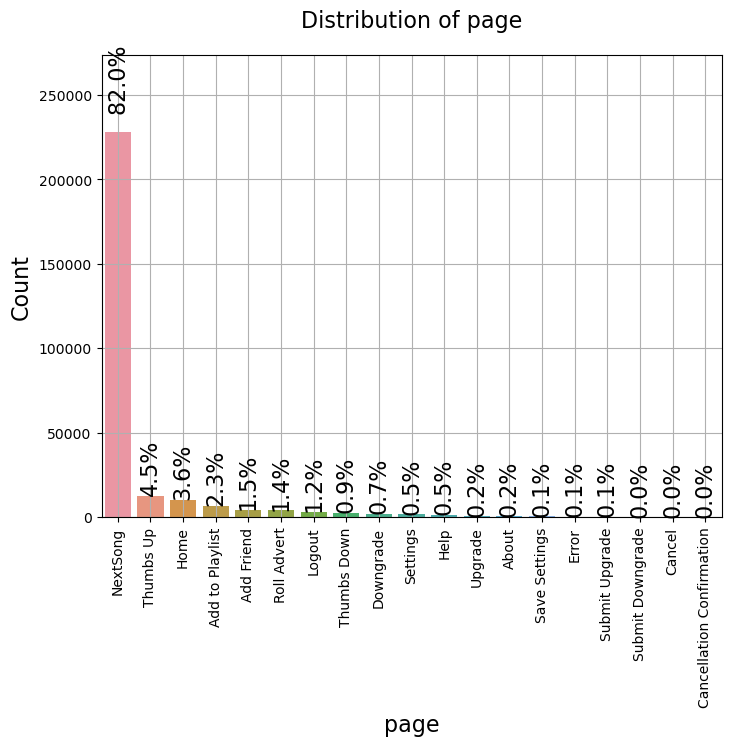

In [38]:
plot_bar(df, 'page', fig_tuple=(8,6), rotation=90, annotation_rotation=90)


### Bivariate Analysis on User Churn

In [39]:
import builtins

def bivariate_plot(df, label, feature, func_label, func_feature, fig_tuple=(8,6),annotation_rotation=0):
    df_pd = df.select(['userId', label, feature]).groupBy('userId').agg({f'{label}':f'{func_label}', f'{feature}':f'{func_feature}'})
    df_pd = df_pd.withColumnRenamed(f"{func_label}({label})", f"{label}")
    df_pd = df_pd.withColumnRenamed(f"{func_feature}({feature})", f"{feature}")
    df_pd = df_pd.toPandas()

    plt.figure(figsize=fig_tuple)
    ax = sns.countplot(x=label, data=df_pd, hue=feature, order=df_pd[label].value_counts().index)
    max_feature = df_pd[feature].value_counts().max()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_ylim(0, max_feature)

    annotate_and_format(ax, df_pd, f'Distribution of {feature} vs {label}', label, 'Count',annotation_rotation)

#### Gender vs Churn

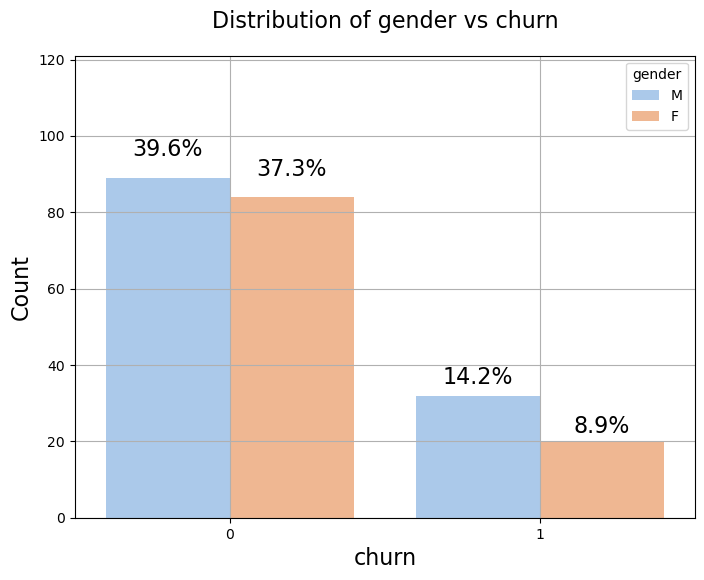

In [40]:
bivariate_plot(df, 'churn', 'gender', 'last', 'last')

#### Level vs Churn

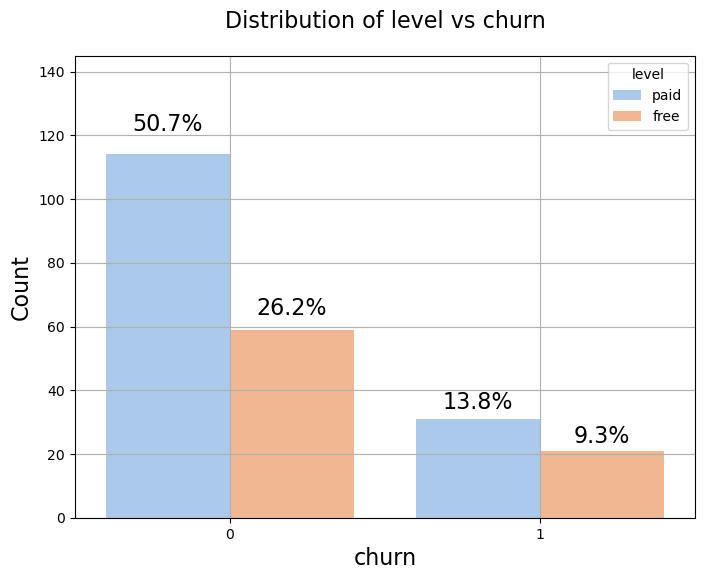

In [41]:
bivariate_plot(df, 'churn', 'level', 'last', 'last')

#### Platform vs Churn

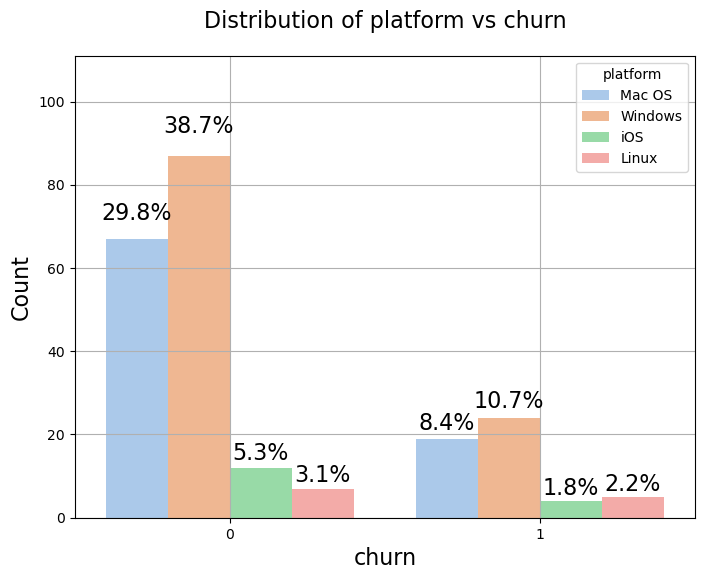

In [42]:
bivariate_plot(df, 'churn', 'platform', 'last', 'last')

#### Browser vs Churn

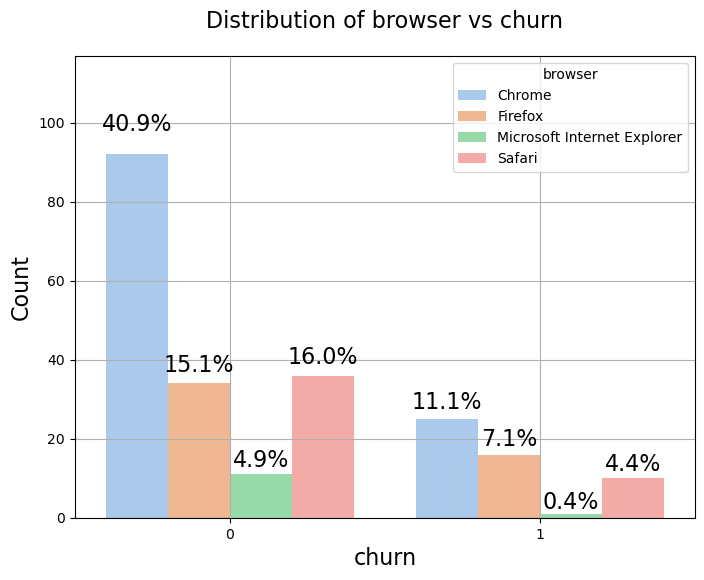

In [43]:
bivariate_plot(df, 'churn', 'browser', 'last', 'last')

#### US Region vs Churn

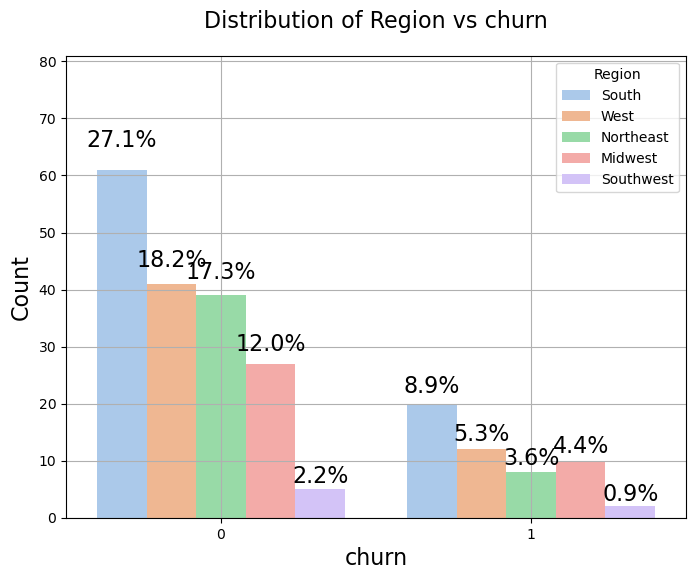

In [44]:
bivariate_plot(df, 'churn', 'Region', 'last', 'last')

### Churn vs Time

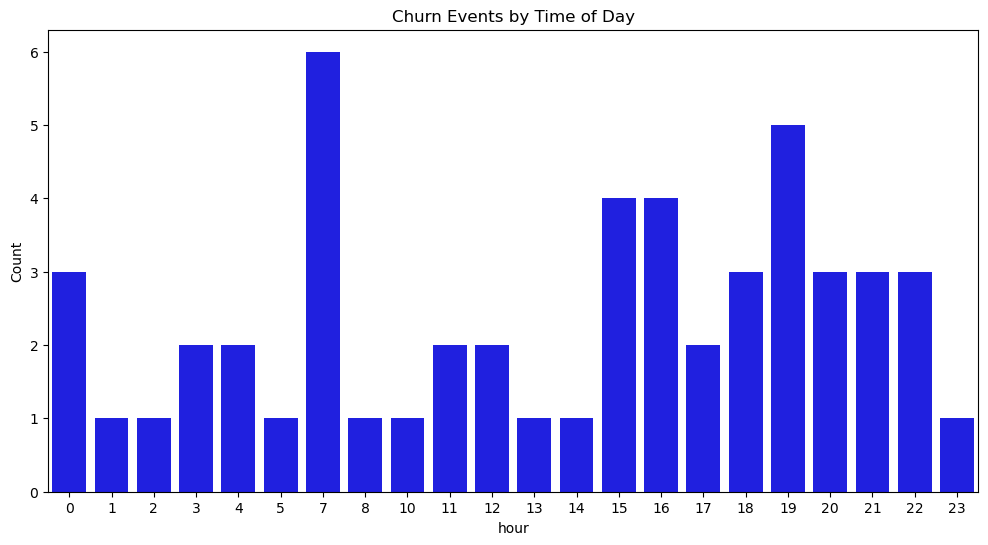

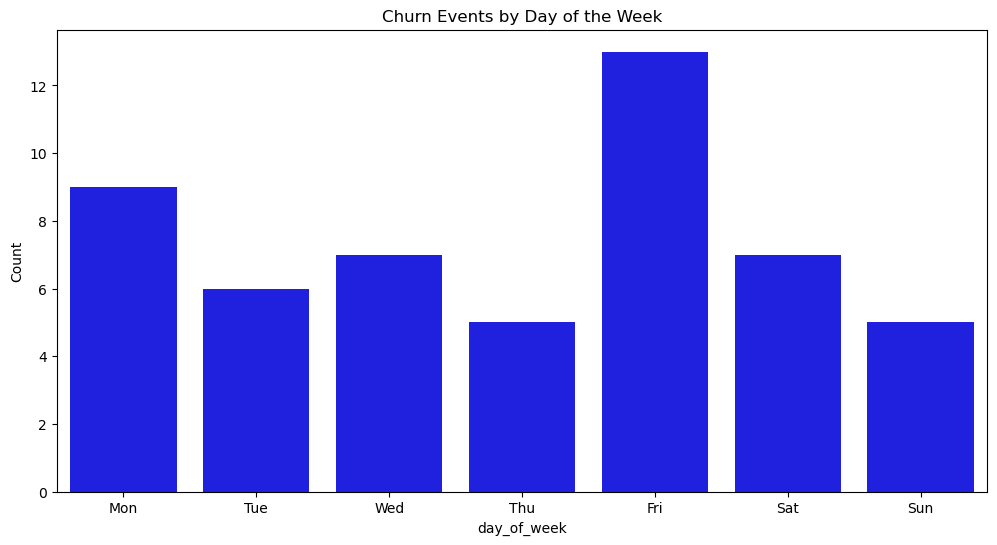

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import from_unixtime, hour, date_format

def plot_churn(df, x, order, title):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=x, order=order, color='blue')
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel(x)
    plt.show()

churn_df = df.filter(df.page == "Cancellation Confirmation")

churn_df = churn_df.withColumn("timestamp", from_unixtime(col("ts") / 1000))
churn_df = churn_df.withColumn("hour", hour("timestamp"))
churn_df = churn_df.withColumn("day_of_week", date_format("timestamp", "E"))

churn_pdf = churn_df.select("hour", "day_of_week").toPandas()

plot_churn(churn_pdf, 'hour', None, 'Churn Events by Time of Day')
plot_churn(churn_pdf, 'day_of_week', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 'Churn Events by Day of the Week')


### Churn vs Page 

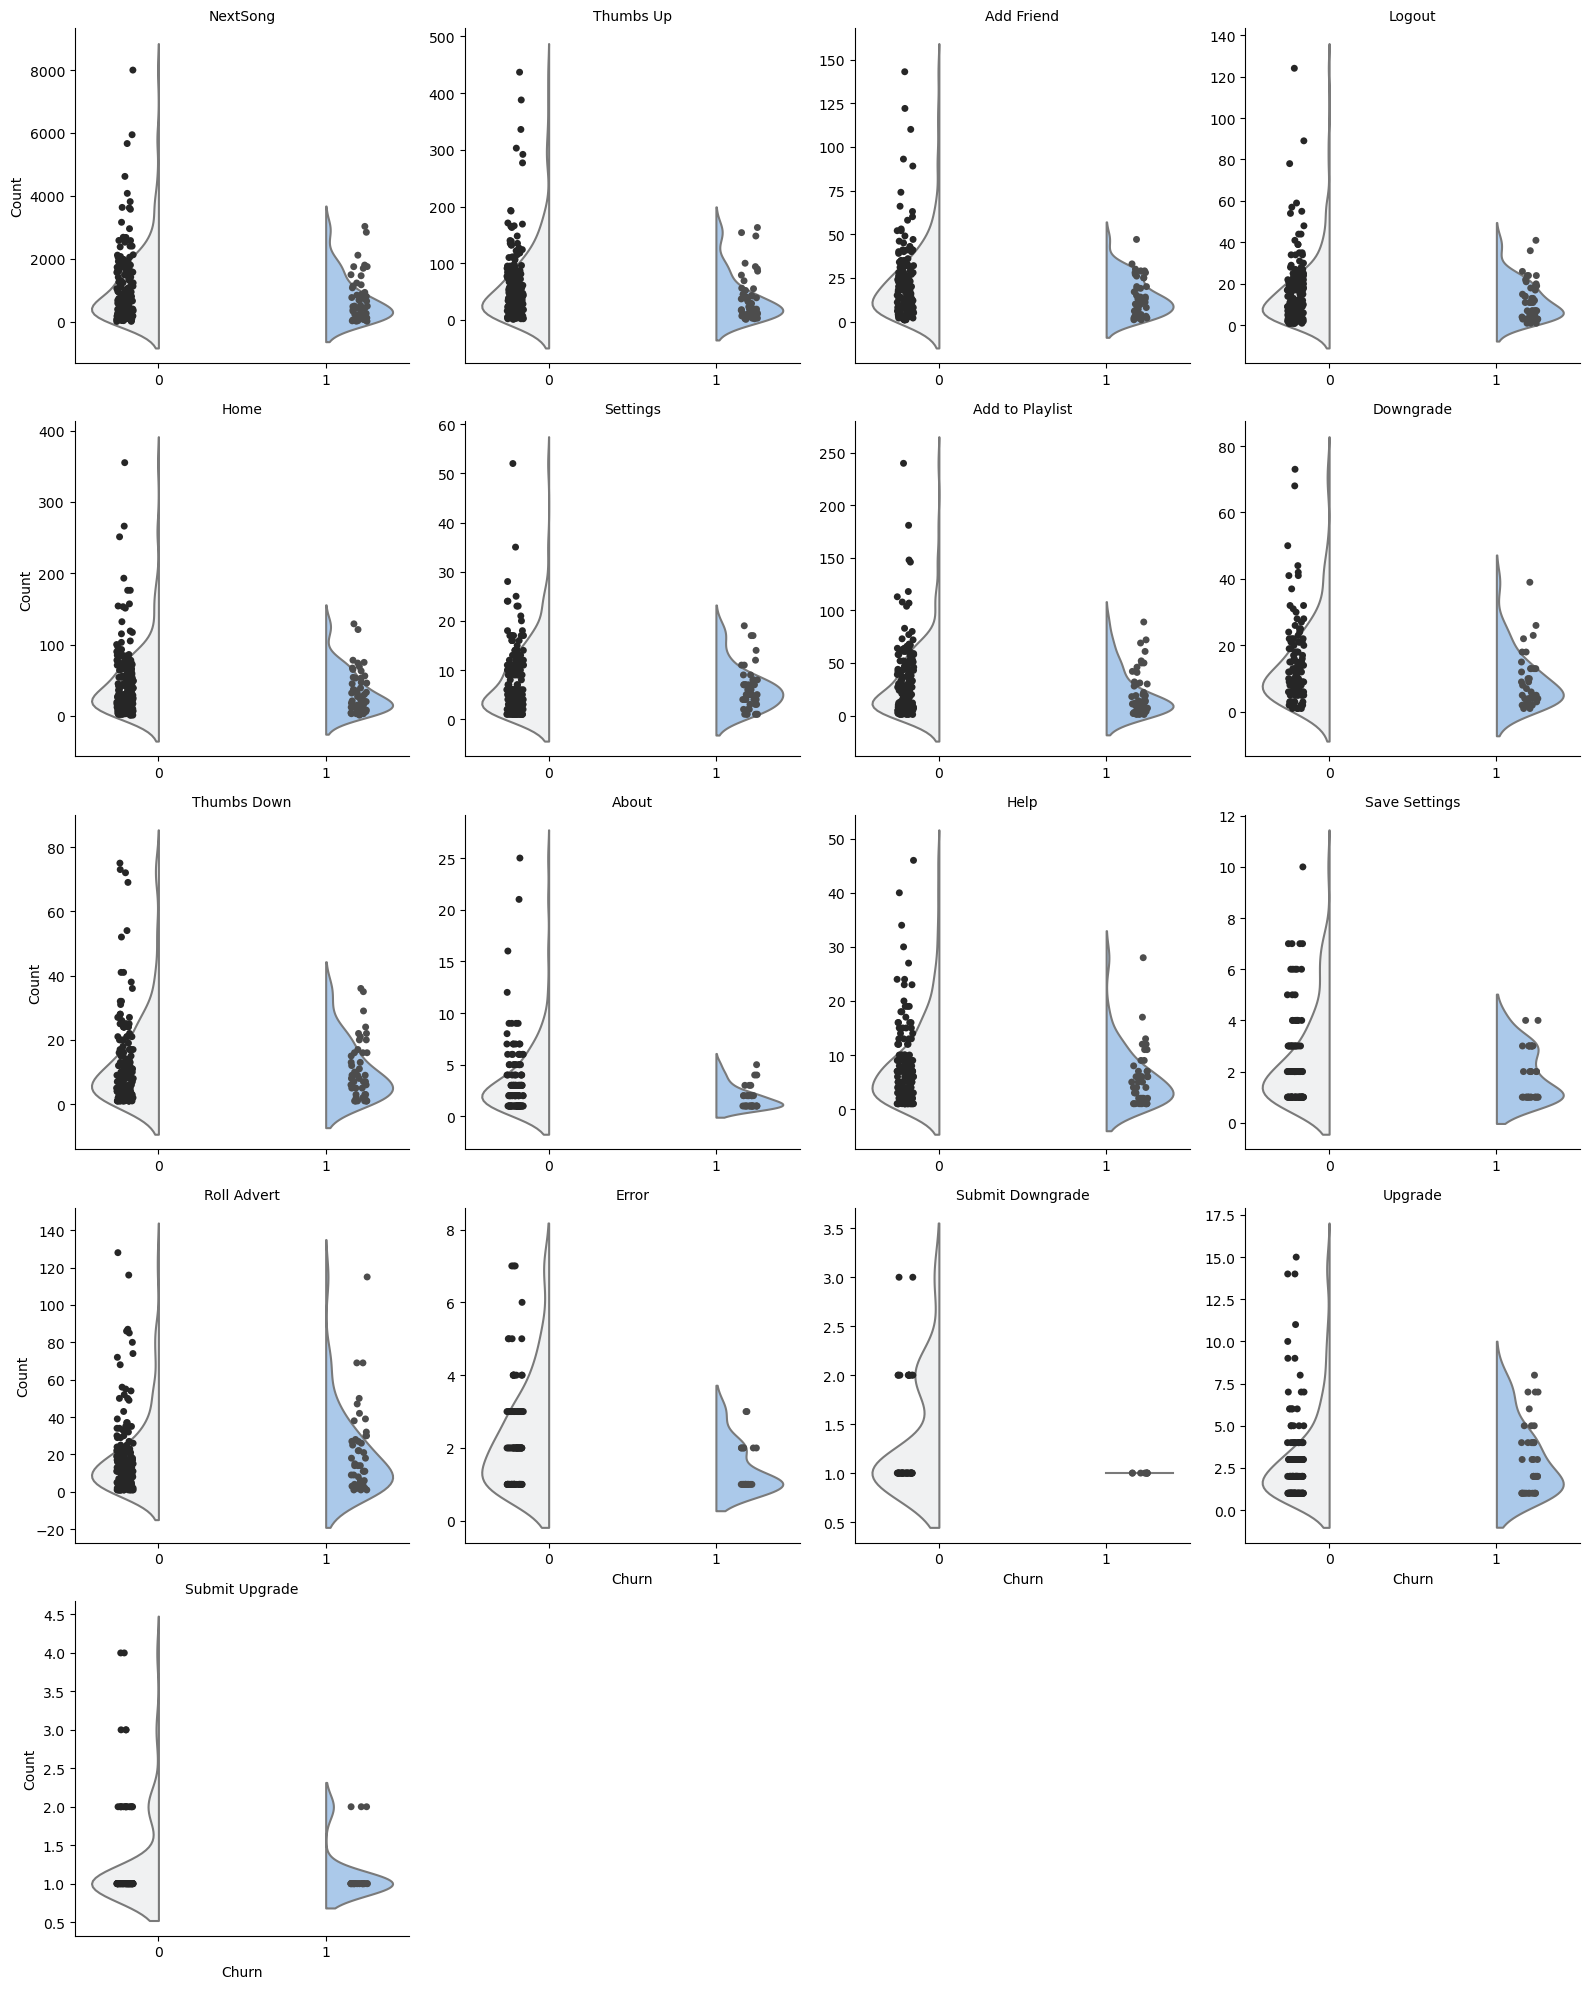

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out unnecessary data first
pages_df = df.filter(~df.page.isin(['Cancel', 'Cancellation Confirmation']))

# Group by userId, page, and churn and count the occurrences of each combination
pages_df = pages_df.groupBy('userId', 'page', 'churn').count()

# Convert to pandas
pages_pd = pages_df.toPandas()

# Create a FacetGrid for the pages, one plot per page
g = sns.FacetGrid(pages_pd, col="page", col_wrap=4, sharey=False, sharex=False, height=4)

# Add strip plots on top
g.map_dataframe(sns.stripplot, x="churn", y="count", hue="churn", dodge=True, jitter=True, palette="dark:.3")

# Create violin plots for each page with hue based on churn
g.map_dataframe(sns.violinplot, x="churn", y="count", hue="churn", split=True, inner=None)



# Set axis labels and titles for subplots
g.set_axis_labels("Churn", "Count")
g.set_titles(col_template="{col_name}")

# Adjust the layout of the subplots
g.tight_layout()

# Show the plot
plt.show()


In [47]:
# Calculate summary statistics for each page, controlling for churn
summary_stats = pages_pd.groupby(['page', 'churn'])['count'].describe()

# Print the summary statistics
print(summary_stats)


                        count         mean          std  min     25%    50%  \
page             churn                                                        
About            0      124.0     3.540323     3.582703  1.0    1.00    3.0   
                 1       31.0     1.806452     1.077632  1.0    1.00    1.0   
Add Friend       0      162.0    22.475309    22.322927  1.0    8.00   17.0   
                 1       44.0    14.454545    10.712858  1.0    6.00   12.5   
Add to Playlist  0      165.0    33.260606    35.177580  1.0    8.00   23.0   
                 1       50.0    20.760000    21.199307  1.0    4.75   12.0   
Downgrade        0      119.0    14.436975    12.752958  1.0    6.00   10.0   
                 1       35.0     9.628571     8.356349  1.0    4.00    7.0   
Error            0       95.0     2.315789     1.467834  1.0    1.00    2.0   
                 1       22.0     1.454545     0.670982  1.0    1.00    1.0   
Help             0      149.0     8.154362     7.680

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [48]:
# Description: This script contains the feature engineering steps for the Sparkify churn prediction model.
from pyspark.sql import DataFrame
from pyspark.sql.functions import udf, when, col, max, min, count, countDistinct, avg, coalesce, first, lag, sum
# from pyspark.sql.types import IntegerType, StructType, StructField, StringType
from pyspark.sql.window import Window
import pyspark.sql.functions as F



# Define constants
PAGES_TO_COUNT = ["NextSong", "Thumbs Up", "Thumbs Down", "Add to Playlist", "Add Friend", "Error", "Help", "Submit Upgrade", "Submit Downgrade", "Roll Advert", "Logout", "Downgrade", "Upgrade", "Settings", "About", "Save Settings"]


class FeatureEngineering:
    def __init__(self, df: DataFrame):
        self.df = df
    
    def feature_engineering(self):
        """
        Perform feature engineering to create features for the model training.
        We aggregate the data by userId and create relevant features given we are predicting churn.
        
        
        Args:
            df (DataFrame): Dataframe containing the data
            
        Returns:
            df (DataFrame): Dataframe containing the engineered features
             
        """
        agg_features = self.aggregate_features()
        agg_features = self.calculate_avg_songs_per_session(agg_features)
        agg_features = self.calculate_time_between_sessions(agg_features)
        agg_features = self.calculate_action_proportions(agg_features)
        agg_features = self.calculate_listening_time_per_session(agg_features)
        agg_features = self.calculate_artists_per_session(agg_features)
        agg_features = self.calculate_stddev_songs_per_session(agg_features)
        agg_features = self.calculate_stddev_time_between_sessions(agg_features)

        # cache the dataframe
        # agg_features = agg_features.cache()

        return agg_features
    
    def aggregate_features(self) -> DataFrame:
        """
        Aggregate the data by userId.
        The aggregation is done the page types that the user interacted with.
        Here are the features that we create:
        - gender
        - level
        - platform
        - browser
        - churn
        - num (page): number of times the user visited the page (e.g. numNextSong, numThumbsUp, etc.)
        - tenure: number of days since registration 
        - num_ads_per_session: number of ads per session
        - avg_unique_artists_per_day: average number of unique artists per day
        - num_sessions: number of sessions
        - num_unique_artists: number of unique artists

        Args:
            df (DataFrame): Dataframe containing the data

        Returns:
            agg_features (DataFrame): Dataframe containing the aggregated features
        """
        agg_dict = {
            "gender": first("gender"),
            "level": first("level"),
            "platform": first("platform"),
            "browser": first("browser"),
            "churn": first("churn"),
            "num_sessions": countDistinct("sessionId"),
            "num_unique_artists": countDistinct("artist")
        }
        # Add page counts to the dictionary using list comprehension
        agg_dict.update({f"num_{page.replace(' ', '_').lower()}": count(when(col("page") == page, 1)) for page in PAGES_TO_COUNT})

        # Update the dictionary for aggregation with new features
        agg_dict.update({
            "tenure": (F.max(col("ts") / 1000) - first(col("registration") / 1000)) / (60 * 60 * 24),
            "num_ads_per_session": count(when(col("page") == "Roll Advert", 1)) / countDistinct("sessionId"),
            "avg_unique_artists_per_day": countDistinct("artist") / ((max("ts") - first("registration")) / (1000 * 60 * 60 * 24) + 1e-6),
        })

        # Aggregating features
        agg_features = self.df.groupBy("userId").agg(*agg_dict.values()).toDF("userId", *agg_dict.keys())
        return agg_features
    
    def calculate_avg_songs_per_session(self, agg_features: DataFrame) -> DataFrame:
        """
        Calculate the average number of songs per session for each user.
        This feature is created to capture the user's listening behavior also we want to gouge his/her degree of engagement with the platform.

        Args:
            agg_features (DataFrame): Dataframe containing the aggregated features

        Returns:
            agg_features (DataFrame): Dataframe containing the aggregated features with avg_songs_per_session added
        """

        songs_per_session = self.df.filter(col("page") == "NextSong").groupBy("userId", "sessionId").count().groupBy("userId").agg(avg("count").alias("avg_songs_per_session"))
        agg_features = agg_features.join(songs_per_session, on="userId")
        return agg_features
    
    def calculate_time_between_sessions(self, agg_features: DataFrame) -> DataFrame:
        """
        Calculate the average time between sessions for each user.
        We expect that users who are more engaged with the platform will have shorter time between sessions.
        
        Args:
            agg_features (DataFrame): Dataframe containing the aggregated features
            
        Returns:
            agg_features (DataFrame): Dataframe containing the aggregated features with avg_time_between_sessions added
        """

        time_between_sessions = self.df.groupBy("userId", "sessionId") \
            .agg((min("ts")/1000).alias("session_start"), first("registration").alias("registration_ts")) \
            .withColumn("prev_session_start", lag("session_start").over(Window.partitionBy("userId").orderBy("session_start"))) \
            .withColumn("prev_session_start", coalesce(col("prev_session_start"), col("registration_ts")/1000)) \
            .withColumn("time_between_sessions", (col("session_start") - col("prev_session_start"))/3600) \
            .groupBy("userId") \
            .agg(avg("time_between_sessions").alias("avg_time_between_sessions"))

        agg_features = agg_features.join(time_between_sessions, on="userId")
        return agg_features
    
    def calculate_action_proportions(self, agg_features: DataFrame) -> DataFrame:
        """
        We exploit the previous aggregation of the page types to calculate the proportion of each page type for each user.
        We create the following features:
        - prop_thumbs_up: proportion of thumbs up
        - prop_add_to_playlist: proportion of add to playlist
        - prop_thumbs_down: proportion of thumbs down
        - unique_artist_ratio: ratio of unique artists to total number of songs

        Args:
            agg_features (DataFrame): Dataframe containing the aggregated features
        
        Returns:
            agg_features (DataFrame): Dataframe containing the aggregated features with the new features added
        
        """


        agg_features = agg_features.withColumn("prop_thumbs_up", col("num_thumbs_up") / col("num_nextsong"))
        agg_features = agg_features.withColumn("prop_add_to_playlist", col("num_add_to_playlist") / col("num_nextsong"))
        agg_features = agg_features.withColumn("prop_thumbs_down", col("num_thumbs_down") / col("num_nextsong"))
        agg_features = agg_features.withColumn("unique_artist_ratio", col("num_unique_artists") / col("num_nextsong"))
        return agg_features
    
    def calculate_listening_time_per_session(self, agg_features: DataFrame) -> DataFrame:
        """
        Calculate the average listening time per session for each user.
        We want to use listening time per session as a proxy for user engagement.
        We expect that users who are more engaged with the platform will have longer listening time per session.
        
        Args:
            agg_features (DataFrame): Dataframe containing the aggregated features
            
        Returns:
            agg_features (DataFrame): Dataframe containing the aggregated features with avg_listening_time_per_session added
        """

        listening_time_per_session = self.df.filter(col("page") == "NextSong").groupBy("userId", "sessionId")\
            .agg(sum("length").alias("session_listening_time"))\
            .groupBy("userId")\
            .agg(avg("session_listening_time").alias("avg_listening_time_per_session"))
        agg_features = agg_features.join(listening_time_per_session, on="userId")
        return agg_features
    
    def calculate_artists_per_session(self, agg_features: DataFrame) -> DataFrame:
        """
        Calculate the average number of artists per session for each user.
        A high number of different artistis per session could indicated that either the user is exploring the platform or that he/she is not satisfied with the current artist.
        Maybe the user is using the service to listen to compilations or playlists, which would lead to a high number of artists per session.
        We expect that users who are more engaged with the platform will have a lower number of artists per session.
        
        Args:
            agg_features (DataFrame): Dataframe containing the aggregated features

        Returns:
            agg_features (DataFrame): Dataframe containing the aggregated features with avg_artists_per_session added
        
        """

        artists_per_session = self.df.filter(col("page") == "NextSong").groupBy("userId", "sessionId").agg(countDistinct("artist").alias("artists_in_session")).groupBy("userId").agg(avg("artists_in_session").alias("avg_artists_per_session"))
        agg_features = agg_features.join(artists_per_session, on="userId")
        return agg_features
    
    def calculate_stddev_songs_per_session(self, agg_features: DataFrame) -> DataFrame:
        """
        Standard deviation of the number of songs per session for each user.
        Stddev is a measure of the spread of the data, which indicates how much the data deviates from the mean.
        Which means that a higher stdev in songs per session indicates that the user may have sessions where he/she explores different artists and genres and other where he exploits.
        If there is too much exploration, this could indicated that he/she is not able to find the music he/she likes.

        Args:
            agg_features (DataFrame): Dataframe containing the aggregated features

        Returns:
            agg_features (DataFrame): Dataframe containing the aggregated features with stddev_songs_per_session added
        """

        stddev_songs_per_session = self.df.filter(col("page") == "NextSong").groupBy("userId", "sessionId").count().groupBy("userId").agg(F.stddev("count").alias("stddev_songs_per_session")).fillna(0)
        agg_features = agg_features.join(stddev_songs_per_session, on="userId")
        return agg_features
    
    def calculate_stddev_time_between_sessions(self, agg_features: DataFrame) -> DataFrame:
        """
        Standard deviation of the time between sessions for each user (Standard deviation is a measure of the spread of the data).
        A high standard deviation in time between sessions could indicate that the user is not using the service regularly.
        Therefore, she/he could potentially churn.

        Args:
            agg_features (DataFrame): Dataframe containing the aggregated features
            
        Returns:
            agg_features (DataFrame): Dataframe containing the aggregated features with stddev_time_between_sessions added
        """
        stddev_time_between_sessions = self.df.groupBy("userId", "sessionId") \
            .agg((min("ts")/1000).alias("session_start"), first("registration").alias("registration_ts")) \
            .withColumn("prev_session_start", lag("session_start").over(Window.partitionBy("userId").orderBy("session_start"))) \
            .withColumn("prev_session_start", coalesce(col("prev_session_start"), col("registration_ts")/1000)) \
            .withColumn("time_between_sessions", (col("session_start") - col("prev_session_start"))/3600) \
            .groupBy("userId") \
            .agg(F.stddev("time_between_sessions").alias("stddev_time_between_sessions")).fillna(0)
        agg_features = agg_features.join(stddev_time_between_sessions, on="userId")
        return agg_features
    
    def get_feature_columns(self, agg_features: DataFrame) -> list:
        """
        Get the list of feature columns.
        The feature columns are the columns that will be used to train the model.
        
        Returns:
            feature_columns (list): List of feature columns
        """
        return [col for col in agg_features.columns if col not in ['userId', 'churn']]
    
    def get_categorical_columns(self) -> list:
        """
        Get the list of categorical columns.
        This is used during the encoding of the categorical features.
        """
        return ['gender', 'level', 'platform', 'browser']
    
    def get_numerical_columns(self, agg_features: DataFrame) -> list:
        """
        Get the list of numerical columns.
        This will be used during numerical feature scaling.
        """
        return [col for col in agg_features.columns if col not in self.get_categorical_columns()]
    
         

In [49]:
# Instantiate the feature engineering class and perform feature engineering
feature_engineering = FeatureEngineering(df)
feature_engineered_data = feature_engineering.feature_engineering()

In [50]:
feature_engineered_data.show(5)

+------+------+-----+--------+-------+-----+------------+------------------+------------+-------------+---------------+-------------------+--------------+---------+--------+------------------+--------------------+---------------+----------+-------------+-----------+------------+---------+-----------------+------------------+-------------------+--------------------------+---------------------+-------------------------+--------------------+--------------------+--------------------+-------------------+------------------------------+-----------------------+------------------------+----------------------------+
|userId|gender|level|platform|browser|churn|num_sessions|num_unique_artists|num_nextsong|num_thumbs_up|num_thumbs_down|num_add_to_playlist|num_add_friend|num_error|num_help|num_submit_upgrade|num_submit_downgrade|num_roll_advert|num_logout|num_downgrade|num_upgrade|num_settings|num_about|num_save_settings|            tenure|num_ads_per_session|avg_unique_artists_per_day|avg_songs_per

In [51]:
from pyspark.sql.functions import count, when, isnan, col
# check if there are any null values
feature_engineered_data.select([count(when(col(c).isNull(), c)).alias(c) for c in feature_engineered_data.columns]).show()

+------+------+-----+--------+-------+-----+------------+------------------+------------+-------------+---------------+-------------------+--------------+---------+--------+------------------+--------------------+---------------+----------+-------------+-----------+------------+---------+-----------------+------+-------------------+--------------------------+---------------------+-------------------------+--------------+--------------------+----------------+-------------------+------------------------------+-----------------------+------------------------+----------------------------+
|userId|gender|level|platform|browser|churn|num_sessions|num_unique_artists|num_nextsong|num_thumbs_up|num_thumbs_down|num_add_to_playlist|num_add_friend|num_error|num_help|num_submit_upgrade|num_submit_downgrade|num_roll_advert|num_logout|num_downgrade|num_upgrade|num_settings|num_about|num_save_settings|tenure|num_ads_per_session|avg_unique_artists_per_day|avg_songs_per_session|avg_time_between_sessions

In [52]:
feature_engineered_data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- num_sessions: long (nullable = false)
 |-- num_unique_artists: long (nullable = false)
 |-- num_nextsong: long (nullable = false)
 |-- num_thumbs_up: long (nullable = false)
 |-- num_thumbs_down: long (nullable = false)
 |-- num_add_to_playlist: long (nullable = false)
 |-- num_add_friend: long (nullable = false)
 |-- num_error: long (nullable = false)
 |-- num_help: long (nullable = false)
 |-- num_submit_upgrade: long (nullable = false)
 |-- num_submit_downgrade: long (nullable = false)
 |-- num_roll_advert: long (nullable = false)
 |-- num_logout: long (nullable = false)
 |-- num_downgrade: long (nullable = false)
 |-- num_upgrade: long (nullable = false)
 |-- num_settings: long (nullable = false)
 |-- num_about: long (nullable = false)
 |-- num_s

In [53]:
features_df = feature_engineered_data.toPandas()

In [54]:
features_df.columns

Index(['userId', 'gender', 'level', 'platform', 'browser', 'churn',
       'num_sessions', 'num_unique_artists', 'num_nextsong', 'num_thumbs_up',
       'num_thumbs_down', 'num_add_to_playlist', 'num_add_friend', 'num_error',
       'num_help', 'num_submit_upgrade', 'num_submit_downgrade',
       'num_roll_advert', 'num_logout', 'num_downgrade', 'num_upgrade',
       'num_settings', 'num_about', 'num_save_settings', 'tenure',
       'num_ads_per_session', 'avg_unique_artists_per_day',
       'avg_songs_per_session', 'avg_time_between_sessions', 'prop_thumbs_up',
       'prop_add_to_playlist', 'prop_thumbs_down', 'unique_artist_ratio',
       'avg_listening_time_per_session', 'avg_artists_per_session',
       'stddev_songs_per_session', 'stddev_time_between_sessions'],
      dtype='object')

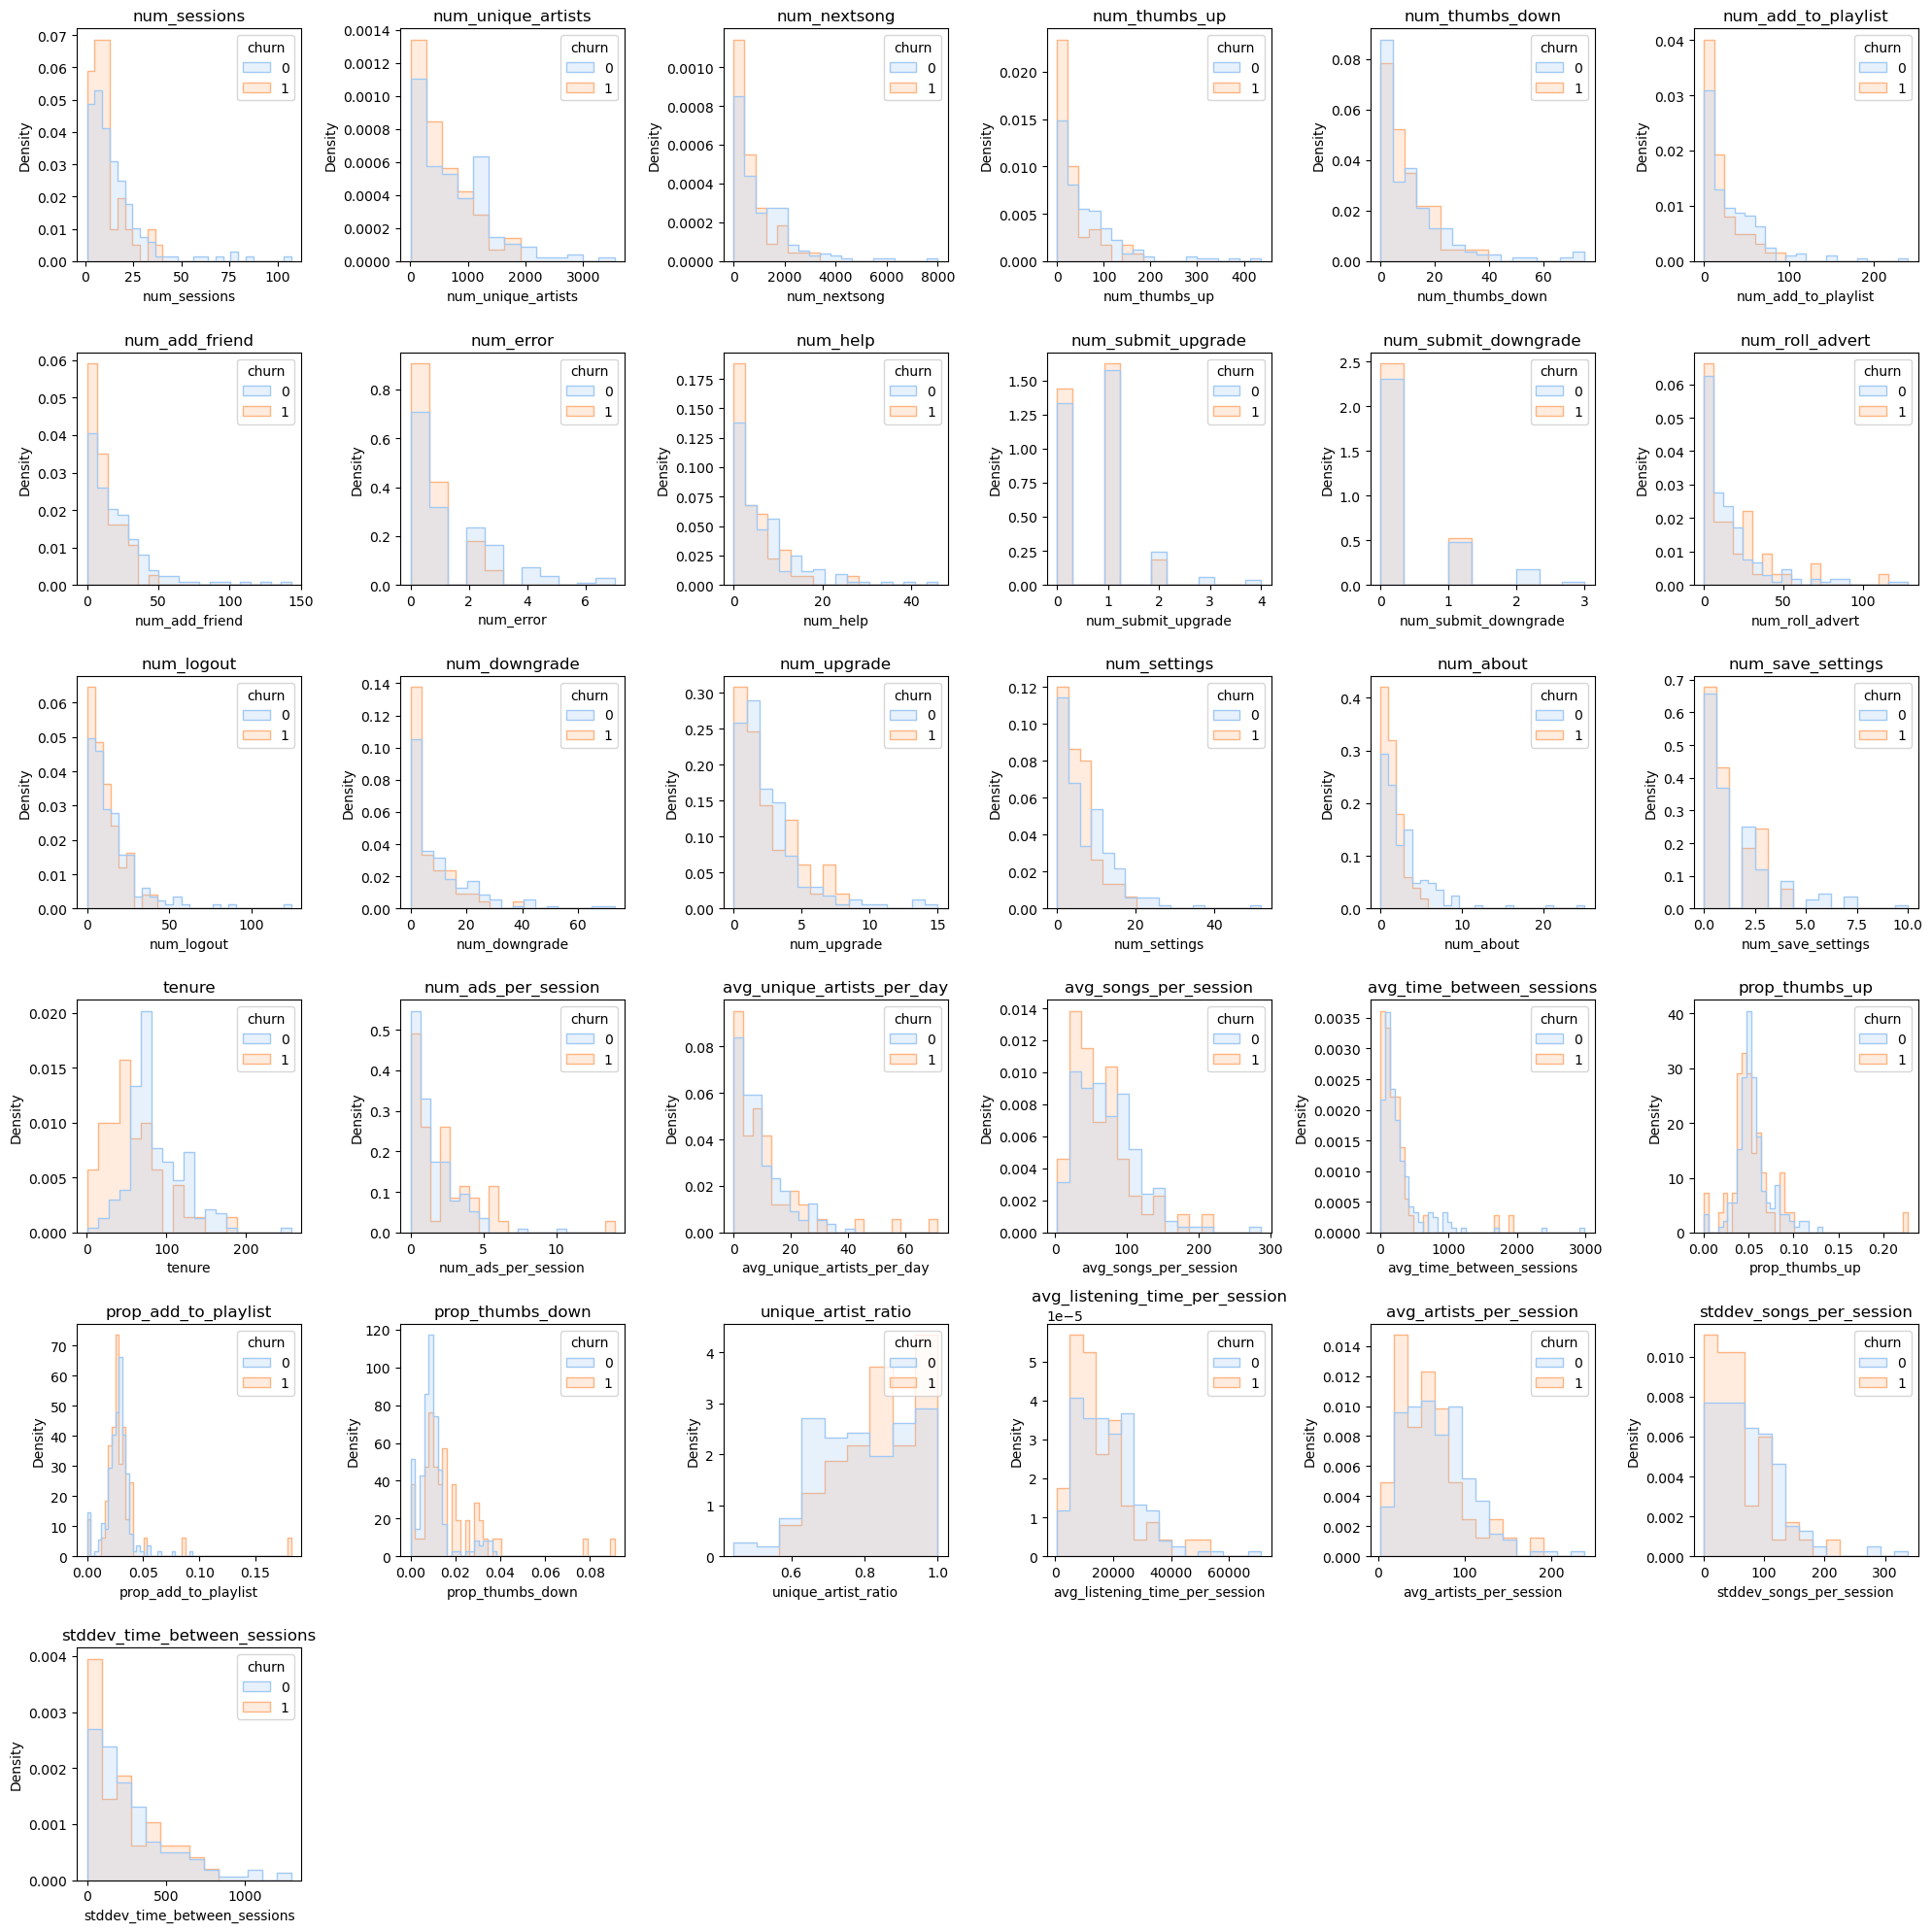

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

excluded_columns = ['churn', 'userId', 'gender', 'level', 'platform', 'browser']

columns_to_plot = [column for column in features_df.columns if column not in excluded_columns]

grid_size = math.ceil(math.sqrt(len(columns_to_plot)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

for ax, column in zip(axs.flatten(), columns_to_plot):
    sns.histplot(data=features_df, x=column, hue="churn", element="step", stat="density", common_norm=False, ax=ax)
    ax.set_title(column)

for ax in axs.flatten()[len(columns_to_plot):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


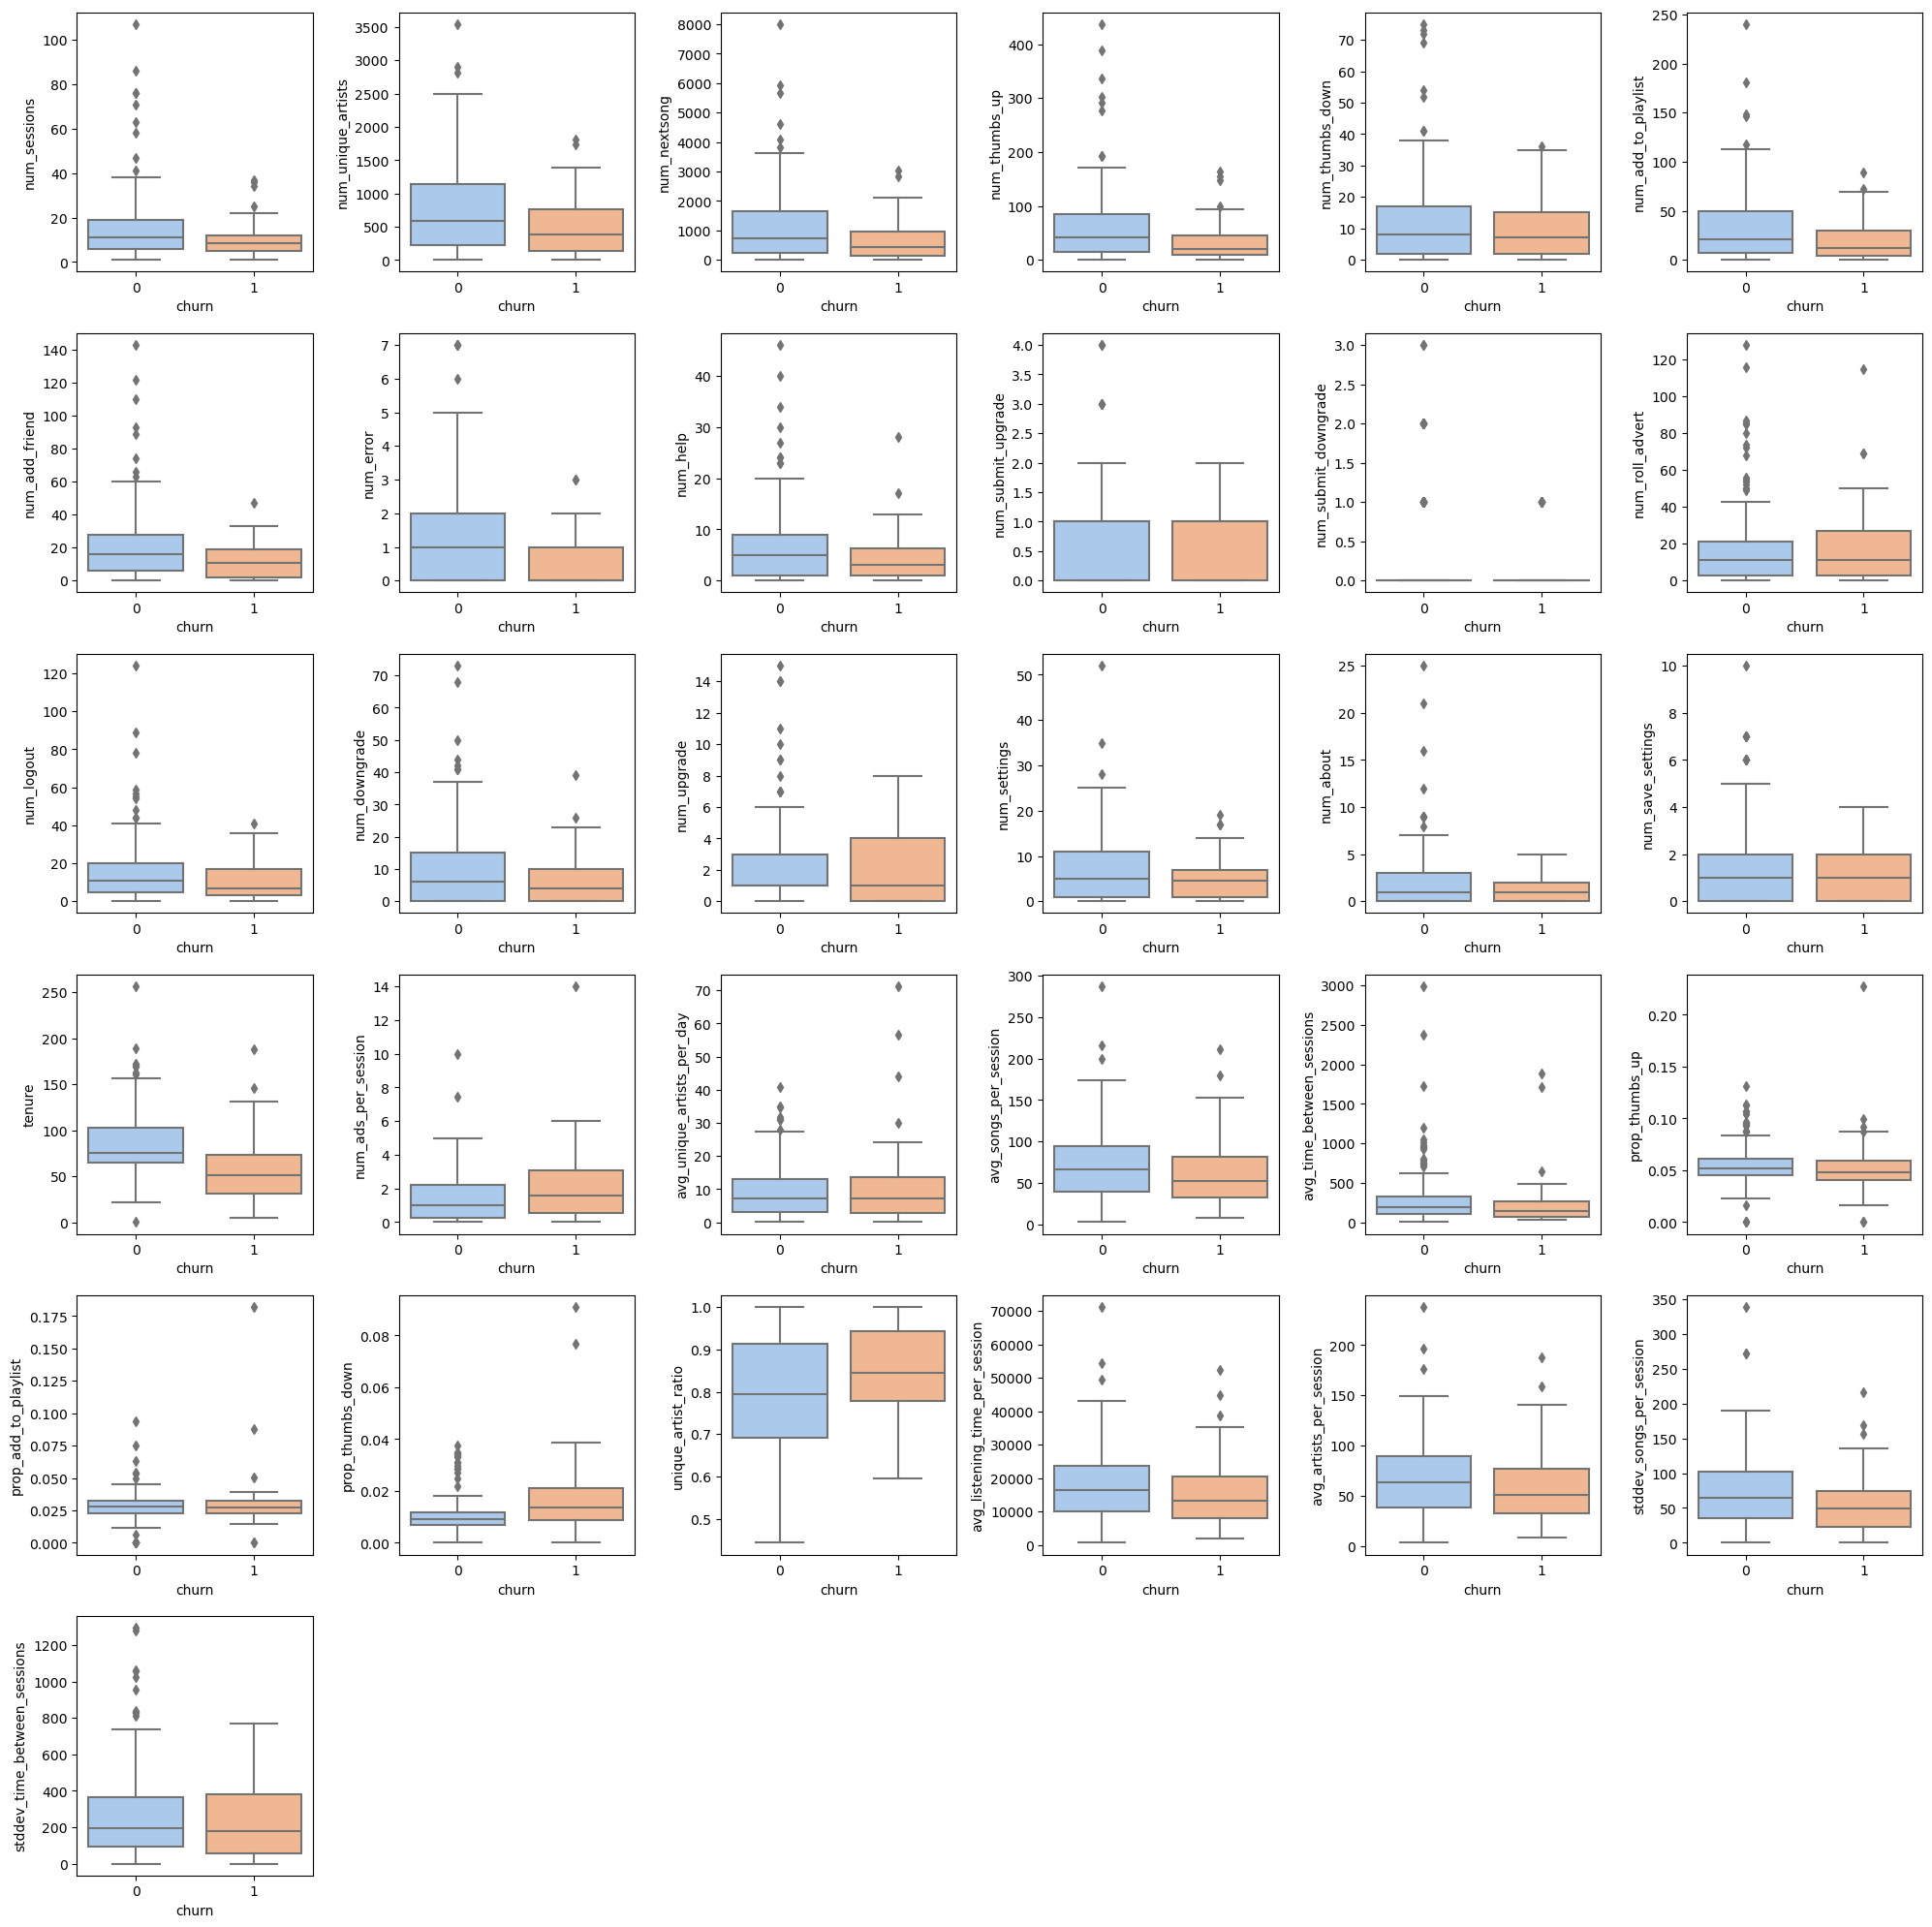

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

grid_size = math.ceil(math.sqrt(len(columns_to_plot)))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

for ax, column in zip(axs.flatten(), columns_to_plot):
    sns.boxplot(x='churn', y=column, data=features_df, ax=ax)

for ax in axs.flatten()[len(columns_to_plot):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


/tmp/ipykernel_31/2677041306.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = features_df.corr()


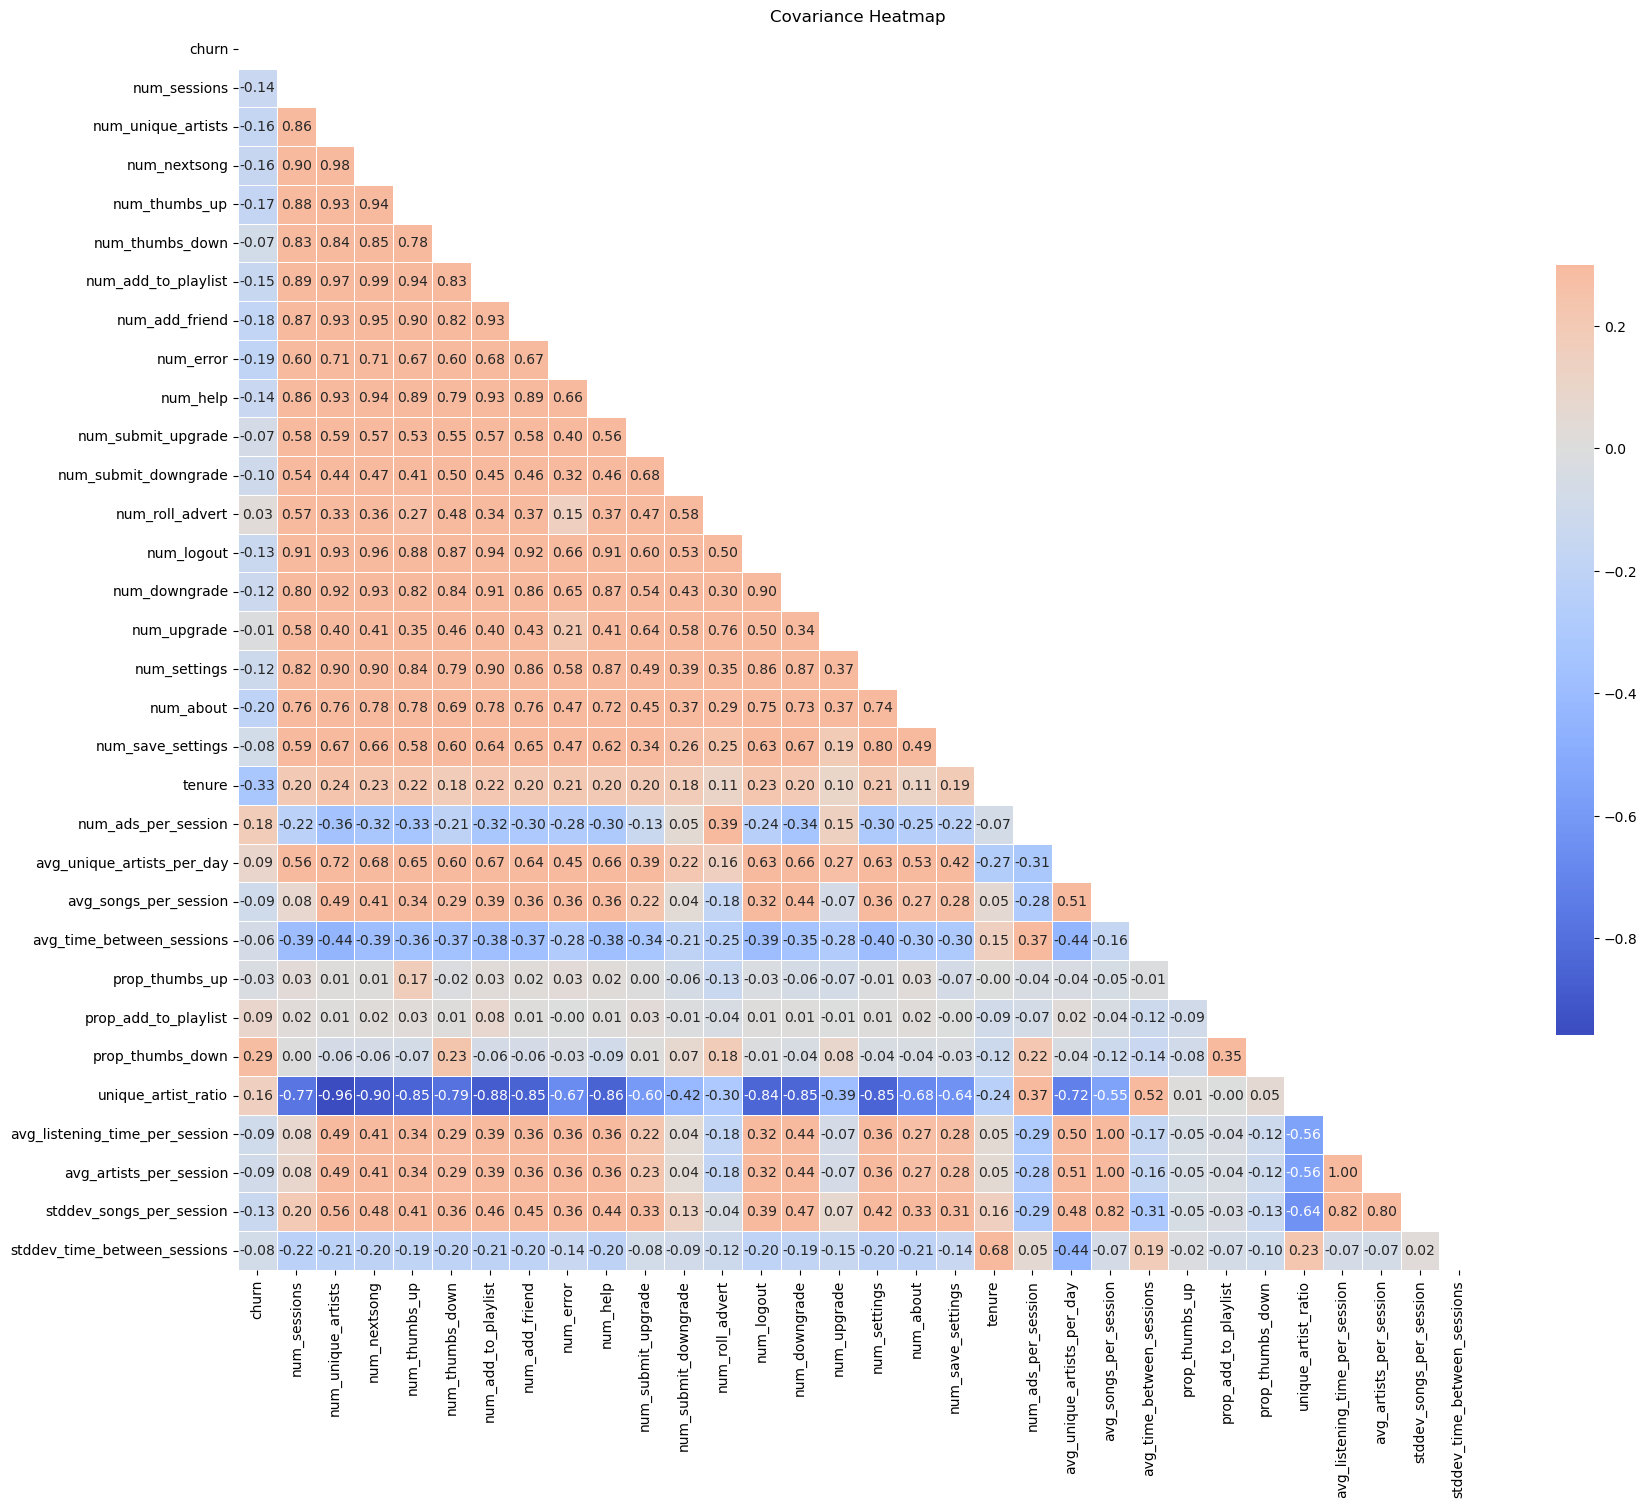

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = features_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Covariance Heatmap')
plt.show()
